## Group No

## Group Member Names:
1. SHIVAM SAHIL - 2023AA05663
2. JAHNAVI GALI - 2023AA05684
3. PRASHANT KUMAR - 2023AA05043
4. SAHIL MEHRA - 2023AA05327

In [2]:
# Install and import necessary libraries

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
import time
import random
from collections import defaultdict
import torch.nn as nn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.ops import box_iou
import warnings
from IPython.display import clear_output
import datetime
import torch.optim as optim
from tqdm import tqdm  # Regular tqdm, not IProgress

warnings.filterwarnings('ignore')

In [3]:
def get_train_directory():
    return r'mot17/MOT17Det/train'
def get_test_directory():
    return r'mot17/MOT17Det/test'
def get_root_directory():
    return r'mot17/MOT17Det'
def get_device():
    device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.mps.is_available() else 'cpu')
    print("Using device:", device)
    return device

def collate_fn(batch):
    """
    Custom collate function for the DataLoader.
    """
    return tuple(zip(*batch))



#### Dataset Structure

```text
- MOT17Det
    - test
        - MOT17-01
            - img1
                - 000001.jpg
                - 000002.jpg
                ...
            - seqinfo.ini
        - MOT17-03
        ...
    - train
        - MOT17-02
            - gt
                - gt.txt 
            - img1
                - 000001.jpg
                - 000002.jpg
                ...
            - seqinfo.ini
        - MOT17-04
        ...
```

- gt.txt content looks like this:
```text
1,1,912,484,97,109,0,7,1
2,1,912,484,97,109,0,7,1
3,1,912,484,97,109,0,7,1
4,1,912,484,97,109,0,7,1
...
```

In [4]:
DATASET_PATH = get_root_directory()
TRAIN_DIR = get_train_directory()
TEST_DIR = get_test_directory()

In [5]:
# Verify dataset paths
def check_dataset_paths():
    """
    Verify that the dataset paths exist and list available sequences.
    """
    if not os.path.exists(DATASET_PATH):
        print(f"Dataset path {DATASET_PATH} does not exist. Please update the path.")
        return False
    
    if not os.path.exists(TRAIN_DIR):
        print(f"Training directory {TRAIN_DIR} does not exist.")
        return False
    
    if not os.path.exists(TEST_DIR):
        print(f"Test directory {TEST_DIR} does not exist.")
        return False
    
    # List available training sequences
    train_sequences = [d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))]
    print(f"Available training sequences ({len(train_sequences)}): {train_sequences}")
    
    # List available test sequences
    test_sequences = [d for d in os.listdir(TEST_DIR) if os.path.isdir(os.path.join(TEST_DIR, d))]
    print(f"Available test sequences ({len(test_sequences)}): {test_sequences}")
    
    return True

check_dataset_paths()

Available training sequences (7): ['MOT17-13', 'MOT17-09', 'MOT17-11', 'MOT17-10', 'MOT17-04', 'MOT17-05', 'MOT17-02']
Available test sequences (7): ['MOT17-12', 'MOT17-14', 'MOT17-07', 'MOT17-08', 'MOT17-01', 'MOT17-06', 'MOT17-03']


True

In [6]:
# Ground truth parsing function
def parse_gt_file(gt_file_path):
    """
    Parse the ground truth file and return a DataFrame with the annotations.
    
    The gt.txt format is:
    <frame>, <id>, <bb_left>, <bb_top>, <bb_width>, <bb_height>, <conf>, <class>, <visibility>
    
    Returns:
        pandas.DataFrame: A DataFrame containing the parsed annotations
    """
    if not os.path.exists(gt_file_path):
        print(f"Ground truth file {gt_file_path} does not exist.")
        return None
    
    # Define column names based on MOT format
    columns = [
        'frame', 'id', 'bb_left', 'bb_top', 'bb_width', 'bb_height', 'conf', 'class', 'visibility'
    ]
    
    # Read the ground truth file
    try:
        gt_df = pd.read_csv(gt_file_path, header=None, names=columns)
        return gt_df
    except Exception as e:
        print(f"Error parsing ground truth file: {e}")
        return None

# Sequence info loading function
def load_sequence_info(sequence_path):
    """
    Load the sequence information from the seqinfo.ini file.
    
    Returns:
        dict: A dictionary containing the sequence information
    """
    seq_info_path = os.path.join(sequence_path, 'seqinfo.ini')
    
    if not os.path.exists(seq_info_path):
        print(f"Sequence info file {seq_info_path} does not exist.")
        return None
    
    # Parse the seqinfo.ini file
    seq_info = {}
    with open(seq_info_path, 'r') as f:
        for line in f.readlines():
            line = line.strip()
            if line.startswith('[') or line == '':
                continue
            key, value = line.split('=')
            seq_info[key.strip()] = value.strip()
    
    return seq_info

In [7]:
# Sample frame loading and visualization function
def load_frame(sequence_path, frame_number):
    """
    Load a specific frame from a sequence.
    
    Args:
        sequence_path (str): Path to the sequence directory
        frame_number (int): Frame number to load
        
    Returns:
        numpy.ndarray: The loaded frame as an BGR image
    """
    # MOT format uses 1-based indexing for frames, with 6-digit zero-padded filenames
    frame_filename = f"{frame_number:06d}.jpg"
    frame_path = os.path.join(sequence_path, 'img1', frame_filename)
    
    if not os.path.exists(frame_path):
        print(f"Frame {frame_path} does not exist.")
        return None
    
    # Read the frame using OpenCV
    frame = cv2.imread(frame_path)
    
    return frame

def visualize_frame_with_annotations(sequence_path, gt_df, frame_number, figsize=(10, 8)):
    """
    Visualize a frame with its ground truth annotations.
    
    Args:
        sequence_path (str): Path to the sequence directory
        gt_df (pandas.DataFrame): DataFrame containing ground truth annotations
        frame_number (int): Frame number to visualize
        figsize (tuple): Figure size for the plot
    """
    # Load the frame
    frame = load_frame(sequence_path, frame_number)
    
    if frame is None:
        return
    
    # Convert from BGR to RGB for matplotlib
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Filter annotations for the current frame
    frame_annotations = gt_df[gt_df['frame'] == frame_number]
    
    # Create figure and axes
    fig, ax = plt.subplots(figsize=figsize)
    
    # Display the frame
    ax.imshow(frame_rgb)
    
    # Generate random colors for each object ID
    unique_ids = frame_annotations['id'].unique()
    color_map = {obj_id: np.random.rand(3,) for obj_id in unique_ids}
    
    # Plot bounding boxes
    for _, row in frame_annotations.iterrows():
        x, y, w, h = row['bb_left'], row['bb_top'], row['bb_width'], row['bb_height']
        obj_id = row['id']
        obj_class = row['class']
        
        # Create rectangle patch
        rect = Rectangle((x, y), w, h, linewidth=2, edgecolor=color_map[obj_id], facecolor='none')
        
        # Add the rectangle to the plot
        ax.add_patch(rect)
        
        # Add label
        if obj_class == 1:  # Person
            class_name = 'Person'
        else:
            class_name = f'Class {obj_class}'
        
        ax.text(x, y-5, f"ID: {obj_id}, {class_name}", color=color_map[obj_id], fontsize=10, 
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    
    # Set title
    ax.set_title(f"Frame {frame_number} with {len(frame_annotations)} objects")
    
    # Remove axes
    ax.axis('off')
    
    plt.tight_layout()
    plt.show()

In [8]:
def load_sample_sequence():
    """
    Load a sample training sequence for exploration.
    
    Returns:
        tuple: (sequence_path, gt_df, seq_info)
    """
    train_sequences = [d for d in os.listdir(TRAIN_DIR) if os.path.isdir(os.path.join(TRAIN_DIR, d))]
    
    if not train_sequences:
        print("No training sequences found.")
        return None, None, None
    
    # Select the first training sequence
    sample_sequence = train_sequences[0]
    sequence_path = os.path.join(TRAIN_DIR, sample_sequence)
    
    # Load ground truth
    gt_file_path = os.path.join(sequence_path, 'gt', 'gt.txt')
    gt_df = parse_gt_file(gt_file_path)
    
    # Load sequence info
    seq_info = load_sequence_info(sequence_path)
    
    print(f"Loaded sample sequence: {sample_sequence}")
    return sequence_path, gt_df, seq_info

## Load a sample sequence and visualize it

Loaded sample sequence: MOT17-13


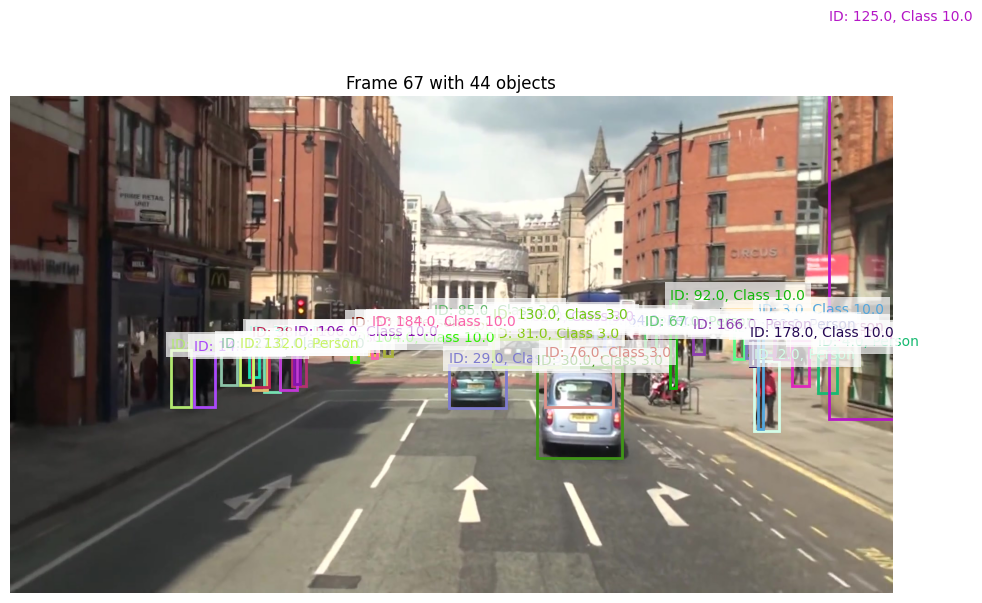

In [9]:
sample_sequence_path, sample_gt_df, sample_seq_info = load_sample_sequence()
if sample_gt_df is not None and sample_sequence_path is not None:
    frame_numbers = sample_gt_df['frame'].unique()
    if len(frame_numbers) > 0:
        random_frame = random.choice(frame_numbers)
        visualize_frame_with_annotations(sample_sequence_path, sample_gt_df, random_frame)

###  Custom Dataset Class and Data Preprocessing

In [10]:
class MOTDataset(Dataset):
    """
    Custom dataset class for MOT17Det dataset.
    
    This class handles:
    1. Loading frames and annotations
    2. Data normalization
    3. Data augmentation
    4. Formatting data for Faster R-CNN
    """
    def __init__(self, root_dir, sequences=None, transform=None, augment=False, test_mode=False):
        """
        Initialize the MOT dataset.
        
        Args:
            root_dir (str): Root directory of the MOT dataset
            sequences (list): List of sequence names to use (if None, use all available sequences)
            transform (callable): Optional transform to be applied to samples
            augment (bool): Whether to apply data augmentation
            test_mode (bool): Whether to use test mode (no ground truth)
        """
        self.root_dir = root_dir
        self.transform = transform
        self.augment = augment
        self.test_mode = test_mode
        
        # Determine the data split (train or test)
        self.split = 'test' if test_mode else 'train'
        split_dir = os.path.join(root_dir, self.split)
        
        # Get available sequences
        if sequences is None:
            self.sequences = [d for d in os.listdir(split_dir) if os.path.isdir(os.path.join(split_dir, d))]
        else:
            self.sequences = sequences
        
        # Initialize data samples list
        self.samples = []
        
        # Populate samples list
        for sequence in self.sequences:
            sequence_path = os.path.join(split_dir, sequence)
            
            # Load sequence info
            seq_info = load_sequence_info(sequence_path)
            if seq_info is None:
                continue
            
            # Get frame range
            frame_count = int(seq_info['seqLength'])
            
            # Load ground truth if in train mode
            gt_df = None
            if not test_mode:
                gt_file_path = os.path.join(sequence_path, 'gt', 'gt.txt')
                gt_df = parse_gt_file(gt_file_path)
                if gt_df is None:
                    continue
            
            # Add samples
            for frame_number in range(1, frame_count + 1):
                # Add frame path and annotations to samples list
                frame_path = os.path.join(sequence_path, 'img1', f"{frame_number:06d}.jpg")
                
                # Skip if frame doesn't exist
                if not os.path.exists(frame_path):
                    continue
                
                # Get annotations for the current frame
                frame_annotations = None
                if gt_df is not None:
                    frame_annotations = gt_df[gt_df['frame'] == frame_number]
                
                self.samples.append({
                    'frame_path': frame_path,
                    'frame_number': frame_number,
                    'sequence': sequence,
                    'annotations': frame_annotations,
                    'seq_info': seq_info
                })
        
        print(f"Loaded {len(self.samples)} samples from {len(self.sequences)} sequences")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        """
        Get a sample from the dataset.
        
        Args:
            idx (int): Index of the sample to get
            
        Returns:
            dict: A dictionary containing the sample data
        """
        sample = self.samples[idx]
        
        # Load the frame
        frame_path = sample['frame_path']
        frame = cv2.imread(frame_path)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert to RGB
        
        # Get annotations
        annotations = sample['annotations']
        
        # Prepare targets for object detection
        if annotations is not None and not self.test_mode:
            # Extract bounding boxes, labels, and object IDs
            boxes = []
            labels = []
            obj_ids = []
            
            for _, row in annotations.iterrows():
                # Extract bounding box coordinates (x, y, width, height)
                x, y, w, h = row['bb_left'], row['bb_top'], row['bb_width'], row['bb_height']
                
                # Convert to (x1, y1, x2, y2) format required by Faster R-CNN
                x1, y1, x2, y2 = x, y, x + w, y + h
                
                # Add bounding box to the list
                boxes.append([x1, y1, x2, y2])
                
                # Add label (MOT17Det has only one class - person, identified by class=1)
                # For Faster R-CNN, we use 1 for person (background is 0)
                labels.append(int(row['class']))
                
                # Add object ID for tracking
                obj_ids.append(int(row['id']))
            
            # Convert to tensors
            if boxes:
                boxes = torch.tensor(boxes, dtype=torch.float32)
                labels = torch.tensor(labels, dtype=torch.int64)
                obj_ids = torch.tensor(obj_ids, dtype=torch.int64)
            else:
                # Empty annotations
                boxes = torch.zeros((0, 4), dtype=torch.float32)
                labels = torch.zeros(0, dtype=torch.int64)
                obj_ids = torch.zeros(0, dtype=torch.int64)
            
            target = {
                'boxes': boxes,
                'labels': labels,
                'image_id': torch.tensor([idx]),
                'obj_ids': obj_ids
            }
        else:
            # No annotations or test mode
            target = {
                'boxes': torch.zeros((0, 4), dtype=torch.float32),
                'labels': torch.zeros(0, dtype=torch.int64),
                'image_id': torch.tensor([idx]),
                'obj_ids': torch.zeros(0, dtype=torch.int64)
            }
        
        # Convert frame to tensor
        frame = F.to_tensor(frame)
        
        # Apply data augmentation if enabled
        if self.augment and not self.test_mode:
            frame, target = self.apply_augmentation(frame, target)
        
        # Apply normalization and other transformations
        if self.transform is not None:
            frame = self.transform(frame)
        
        return frame, target, sample
    
    def apply_augmentation(self, image, target):
        """
        Apply data augmentation to the image and target.
        
        Args:
            image (torch.Tensor): Image tensor [C, H, W]
            target (dict): Target dictionary with boxes, labels, etc.
            
        Returns:
            tuple: (augmented_image, augmented_target)
        """
        # Skip augmentation if there are no boxes
        if target['boxes'].shape[0] == 0:
            return image, target
        
        # Convert image to PIL for some augmentations
        image_pil = F.to_pil_image(image)
        boxes = target['boxes']
        
        # Random horizontal flip with 50% probability
        if random.random() > 0.5:
            image_pil = F.hflip(image_pil)
            width = image.shape[2]
            # Flip bounding boxes
            boxes[:, [0, 2]] = width - boxes[:, [2, 0]]
        
        # Random brightness and contrast adjustment
        if random.random() > 0.5:
            brightness_factor = random.uniform(0.8, 1.2)
            contrast_factor = random.uniform(0.8, 1.2)
            image_pil = F.adjust_brightness(image_pil, brightness_factor)
            image_pil = F.adjust_contrast(image_pil, contrast_factor)
        
        # Random color jittering for robustness
        if random.random() > 0.5:
            saturation_factor = random.uniform(0.8, 1.2)
            hue_factor = random.uniform(-0.1, 0.1)
            image_pil = F.adjust_saturation(image_pil, saturation_factor)
            image_pil = F.adjust_hue(image_pil, hue_factor)
        
        # Convert back to tensor
        image = F.to_tensor(image_pil)
        
        # Update target with augmented boxes
        target['boxes'] = boxes
        
        return image, target


### Data normalization and transformation functions

In [11]:
class Normalize(object):
    """
    Normalize a tensor with mean and standard deviation.
    """
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image to be normalized
        Returns:
            Tensor: Normalized image
        """
        return F.normalize(tensor, mean=self.mean, std=self.std)


def get_transform(train):
    """
    Get transformation for the dataset.
    
    Args:
        train (bool): Whether to use training transformations
        
    Returns:
        callable: Transformation function
    """
    transforms = []
    
    transforms.append(Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
    
    return torchvision.transforms.Compose(transforms)

# Function to create train and validation datasets
def create_datasets(dataset_path, val_sequences=None, augment=True):
    """
    Create training and validation datasets.
    
    Args:
        dataset_path (str): Path to the MOT dataset
        val_sequences (list): List of sequence names to use for validation
        augment (bool): Whether to apply data augmentation
        
    Returns:
        tuple: (train_dataset, val_dataset)
    """
    # Get all available training sequences
    train_dir = os.path.join(dataset_path, 'train')
    all_sequences = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
    
    # If validation sequences are not specified, use 20% of sequences for validation
    if val_sequences is None:
        random.shuffle(all_sequences)
        split_idx = max(1, int(len(all_sequences) * 0.8))  # Ensure at least one sequence for validation
        train_sequences = all_sequences[:split_idx]
        val_sequences = all_sequences[split_idx:]
    else:
        train_sequences = [seq for seq in all_sequences if seq not in val_sequences]
    
    print(f"Using {len(train_sequences)} sequences for training and {len(val_sequences)} for validation")
    
    # Create training dataset
    train_dataset = MOTDataset(
        root_dir=dataset_path,
        sequences=train_sequences,
        transform=get_transform(train=True),
        augment=augment,
        test_mode=False
    )
    
    # Create validation dataset
    val_dataset = MOTDataset(
        root_dir=dataset_path,
        sequences=val_sequences,
        transform=get_transform(train=False),
        augment=False,
        test_mode=False
    )
    
    return train_dataset, val_dataset

# Visualization function to verify the dataset and augmentation
def visualize_dataset_sample(dataset, sample_idx=0, show_augmented=False):
    """
    Visualize a sample from the dataset with or without augmentation.
    
    Args:
        dataset (MOTDataset): Dataset to visualize
        sample_idx (int): Index of the sample to visualize
        show_augmented (bool): Whether to show augmentation effects
    """
    # Get the sample
    image, target, sample_info = dataset[sample_idx]
    
    # If showing augmentation, apply it manually
    if show_augmented and dataset.augment:
        # Get original image without augmentation
        dataset_no_aug = MOTDataset(
            root_dir=dataset.root_dir,
            sequences=[sample_info['sequence']],
            transform=None,
            augment=False,
            test_mode=dataset.test_mode
        )
        
        # Find matching sample in non-augmented dataset
        for i in range(len(dataset_no_aug)):
            _, _, info = dataset_no_aug[i]
            if (info['sequence'] == sample_info['sequence'] and
                info['frame_number'] == sample_info['frame_number']):
                orig_image, orig_target, _ = dataset_no_aug[i]
                break
        else:
            print("Couldn't find matching sample without augmentation")
            return
        
        # Display both original and augmented images
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        
        # Convert tensors back to numpy for visualization
        orig_image_np = orig_image.permute(1, 2, 0).numpy()
        image_np = image.permute(1, 2, 0).numpy()
        
        # Denormalize if transform was applied
        if dataset.transform is not None:
            # Approximate denormalization
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image_np = std * image_np + mean
            image_np = np.clip(image_np, 0, 1)
        
        # Display original image with boxes
        axes[0].imshow(orig_image_np)
        axes[0].set_title("Original Image")
        
        # Display boxes on original image
        for box in orig_target['boxes']:
            x1, y1, x2, y2 = box.numpy()
            rect = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none')
            axes[0].add_patch(rect)
        
        # Display augmented image with boxes
        axes[1].imshow(image_np)
        axes[1].set_title("Augmented Image")
        
        # Display boxes on augmented image
        for box in target['boxes']:
            x1, y1, x2, y2 = box.numpy()
            rect = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none')
            axes[1].add_patch(rect)
        
        axes[0].axis('off')
        axes[1].axis('off')
        plt.tight_layout()
        plt.show()
    else:
        # Simply display the single image with boxes
        # Convert tensor back to numpy for visualization
        image_np = image.permute(1, 2, 0).numpy()
        
        # Denormalize if transform was applied
        if dataset.transform is not None:
            # Approximate denormalization
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image_np = std * image_np + mean
            image_np = np.clip(image_np, 0, 1)
        
        plt.figure(figsize=(10, 6))
        plt.imshow(image_np)
        
        # Display boxes
        for box in target['boxes']:
            x1, y1, x2, y2 = box.numpy()
            rect = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='r', facecolor='none')
            plt.gca().add_patch(rect)
        
        plt.title(f"Sample from {sample_info['sequence']}, Frame {sample_info['frame_number']}")
        plt.axis('off')
        plt.tight_layout()
        plt.show()

Using 5 sequences for training and 2 for validation
Loaded 4191 samples from 5 sequences
Loaded 1125 samples from 2 sequences


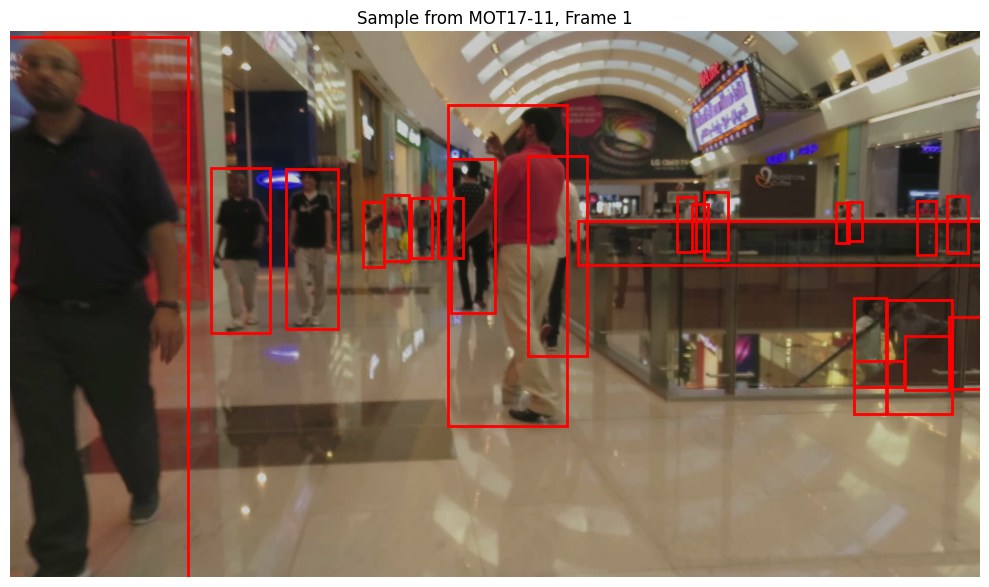

Loaded 900 samples from 1 sequences


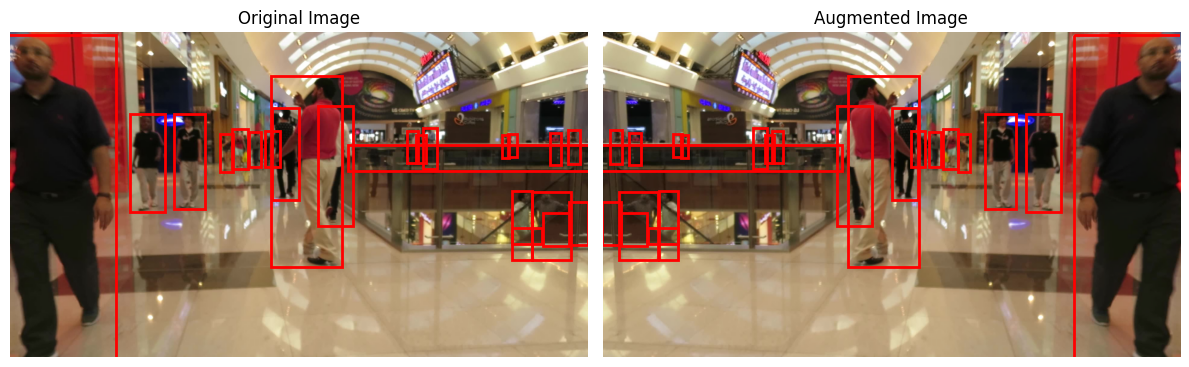

In [12]:
# Example usage:
# Create sample datasets
train_dataset, val_dataset = create_datasets(DATASET_PATH)

# Visualize a sample from the training dataset
if len(train_dataset) > 0:
    # Show original sample
    visualize_dataset_sample(train_dataset, sample_idx=0, show_augmented=False)
    
    # Show augmentation effects
    visualize_dataset_sample(train_dataset, sample_idx=0, show_augmented=True)

### Advanced Object Tracking and Detection in Video Streams

#### Part 3: Model Development - Faster R-CNN and Tracking

This integrates the Faster R-CNN model with tracking capabilities. It uses a pretrained Faster R-CNN model with ResNet50 backbone and FPN (Feature Pyramid Network) for object detection.

In [13]:
class FasterRCNNTracker(nn.Module):
    """
    Faster R-CNN model with tracking capabilities.
    
    This model combines the Faster R-CNN object detector with 
    temporal consistency checks and adaptive tracking.
    """
    def __init__(self, num_classes=2, pretrained=True):
        """
        Initialize the model.
        
        Args:
            num_classes (int): Number of classes to detect (including background)
            pretrained (bool): Whether to use pretrained weights
        """
        super(FasterRCNNTracker, self).__init__()
        
        # Initialize the Faster R-CNN model
        if pretrained:
            # Use pretrained weights
            weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
            self.model = fasterrcnn_resnet50_fpn(weights=weights)
            
            # Replace the classification head with a new one for our classes
            in_features = self.model.roi_heads.box_predictor.cls_score.in_features
            self.model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        else:
            # Initialize with random weights
            self.model = fasterrcnn_resnet50_fpn(num_classes=num_classes)
        
        # Tracking state
        self.tracks = {}  # Dictionary to store active tracks: {track_id: track_info}
        self.next_track_id = 0  # Next available track ID
        
        # Tracking parameters
        self.detection_threshold = 0.7  # Minimum detection confidence
        self.iou_threshold = 0.3  # Minimum IoU for track association
        self.max_age = 30  # Maximum frames to keep a track alive without matches
        
        # Kalman filter parameters for adaptive tracking
        self.use_kalman = True  # Whether to use Kalman filtering
        self.kalman_states = {}  # Dictionary to store Kalman filter states
    
    def forward(self, images, targets=None):
        """
        Forward pass for training and inference.
        
        Args:
            images (list): List of input images
            targets (list, optional): List of target dictionaries for training
            
        Returns:
            dict or losses: Detection results or training losses
        """
        return self.model(images, targets)
    
    def detect(self, image, threshold=None):
        """
        Perform object detection on a single image.
        
        Args:
            image (torch.Tensor): Input image tensor
            threshold (float, optional): Detection confidence threshold
            
        Returns:
            dict: Dictionary with detection results
        """
        # Set threshold
        if threshold is None:
            threshold = self.detection_threshold
        
        # Set model to evaluation mode
        self.model.eval()
        
        # Move image to the correct device
        device = next(self.model.parameters()).device
        image = image.to(device)
        
        # Perform inference
        with torch.no_grad():
            prediction = self.model([image])
        
        # Get predictions for the first (and only) image
        boxes = prediction[0]['boxes'].cpu()
        scores = prediction[0]['scores'].cpu()
        labels = prediction[0]['labels'].cpu()
        
        # Filter by threshold
        keep = scores > threshold
        boxes = boxes[keep]
        scores = scores[keep]
        labels = labels[keep]
        
        return {
            'boxes': boxes,
            'scores': scores,
            'labels': labels
        }

#### Kalman Filter implementation for object tracking

A complete implementation of the Kalman Filter algorithm for adaptive tracking. The Kalman filter predicts object positions based on their previous movements, which is especially useful when objects are temporarily occluded or detection is unreliable.

In [14]:
class KalmanFilter:
    """
    Kalman Filter implementation for bounding box tracking.
    
    This provides adaptive tracking by predicting object positions
    based on previous observations and current measurements.
    """
    def __init__(self, initial_state):
        """
        Initialize Kalman Filter with initial state.
        
        Args:
            initial_state (numpy.ndarray): Initial state [x, y, w, h, vx, vy, vw, vh]
        """
        # State dimensions
        self.dim_x = 8  # State vector dimension [x, y, w, h, vx, vy, vw, vh]
        self.dim_z = 4  # Measurement vector dimension [x, y, w, h]
        
        # State vector
        self.x = np.array(initial_state, dtype=float)
        
        # State transition matrix (motion model)
        self.F = np.eye(self.dim_x)
        # Position updates based on velocity
        self.F[0, 4] = 1.0  # x += vx
        self.F[1, 5] = 1.0  # y += vy
        self.F[2, 6] = 1.0  # w += vw
        self.F[3, 7] = 1.0  # h += vh
        
        # Measurement matrix (maps state to measurement)
        self.H = np.zeros((self.dim_z, self.dim_x))
        self.H[0, 0] = 1.0  # Measure x
        self.H[1, 1] = 1.0  # Measure y
        self.H[2, 2] = 1.0  # Measure w
        self.H[3, 3] = 1.0  # Measure h
        
        # Covariance matrix
        self.P = np.eye(self.dim_x) * 100.0
        
        # Process noise covariance
        self.Q = np.eye(self.dim_x) * 0.01
        self.Q[4:, 4:] *= 0.1  # Lower process noise for velocity components
        
        # Measurement noise covariance
        self.R = np.eye(self.dim_z) * 1.0
        
        # Identity matrix
        self.I = np.eye(self.dim_x)
    
    def predict(self):
        """
        Predict the next state based on the current state.
        
        Returns:
            numpy.ndarray: Predicted measurement [x, y, w, h]
        """
        # State prediction
        self.x = np.dot(self.F, self.x)
        
        # Covariance prediction
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q
        
        # Return predicted measurement
        return np.dot(self.H, self.x)
    
    def update(self, z):
        """
        Update the state based on the measurement.
        
        Args:
            z (numpy.ndarray): Measurement [x, y, w, h]
        """
        # Measurement residual
        y = z - np.dot(self.H, self.x)
        
        # Residual covariance
        S = np.dot(np.dot(self.H, self.P), self.H.T) + self.R
        
        # Kalman gain
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))
        
        # State update
        self.x = self.x + np.dot(K, y)
        
        # Covariance update
        self.P = np.dot((self.I - np.dot(K, self.H)), self.P)
    
    def get_state(self):
        """
        Get the current state.
        
        Returns:
            numpy.ndarray: Current state [x, y, w, h, vx, vy, vw, vh]
        """
        return self.x.copy()



#### Temporal consistency tracker

This implements the temporal consistency checks to ensure that detected objects maintain consistent identities across frames using IoU-based matching and the Kalman Filter.

In [15]:
class TemporalConsistencyTracker:
    """
    Implements temporal consistency checks for object tracking.
    
    This tracker ensures that detected objects maintain consistent
    identities across frames by using IoU-based matching and Kalman filtering.
    """
    def __init__(self, iou_threshold=0.3, max_age=30, min_hits=3, detection_threshold=0.7):
        """
        Initialize the tracker.
        
        Args:
            iou_threshold (float): Minimum IoU for track association
            max_age (int): Maximum frames to keep a track alive without matches
            min_hits (int): Minimum hits before a track is considered valid
            detection_threshold (float): Minimum detection confidence
        """
        self.iou_threshold = iou_threshold
        self.max_age = max_age
        self.min_hits = min_hits
        self.detection_threshold = detection_threshold
        
        self.tracks = {}  # Active tracks: {track_id: track_info}
        self.next_track_id = 0  # Next available track ID
        
        # Flags
        self.use_kalman = True  # Whether to use Kalman filtering
    
    def update(self, detections, frame_id):
        """
        Update tracks with new detections.
        
        Args:
            detections (dict): Detection results with 'boxes', 'scores', 'labels'
            frame_id (int): Current frame ID
            
        Returns:
            dict: Current tracks
        """
        # Get detection boxes and scores
        detected_boxes = detections['boxes']
        detected_scores = detections['scores']
        detected_labels = detections['labels']
        
        # Initialize arrays to keep track of matches
        matched_track_indices = []
        matched_detection_indices = []
        
        # Compute IoU between tracks and detections
        if self.tracks and len(detected_boxes) > 0:
            # Extract track boxes
            track_ids = list(self.tracks.keys())
            track_boxes = torch.stack([self.tracks[track_id]['box'] for track_id in track_ids])
            
            # Calculate IoU matrix
            iou_matrix = box_iou(track_boxes, detected_boxes)
            
            # Match tracks to detections based on IoU
            for track_idx, track_id in enumerate(track_ids):
                # Get best matching detection for this track
                if torch.any(iou_matrix[track_idx] >= self.iou_threshold):
                    # Get detection with highest IoU
                    det_idx = torch.argmax(iou_matrix[track_idx]).item()
                    
                    # If detection already matched to another track, keep the one with higher IoU
                    if det_idx in matched_detection_indices:
                        # Find the track that already matched to this detection
                        existing_match_idx = matched_detection_indices.index(det_idx)
                        existing_track_idx = matched_track_indices[existing_match_idx]
                        existing_track_id = track_ids[existing_track_idx]
                        
                        # Compare IoUs
                        if iou_matrix[track_idx, det_idx] > iou_matrix[existing_track_idx, det_idx]:
                            # Current track has higher IoU, update the match
                            matched_track_indices[existing_match_idx] = track_idx
                            self._update_track(track_id, detected_boxes[det_idx], detected_scores[det_idx], 
                                              detected_labels[det_idx], frame_id)
                            
                            # Mark the existing track as unmatched
                            self.tracks[existing_track_id]['age'] += 1
                        else:
                            # Existing track has higher IoU, keep it and mark current track as unmatched
                            self.tracks[track_id]['age'] += 1
                    else:
                        # This is a new match
                        matched_track_indices.append(track_idx)
                        matched_detection_indices.append(det_idx)
                        self._update_track(track_id, detected_boxes[det_idx], detected_scores[det_idx], 
                                          detected_labels[det_idx], frame_id)
                else:
                    # No match for this track, increase age
                    self.tracks[track_id]['age'] += 1
        
        # Initialize new tracks for unmatched detections
        for det_idx, (box, score, label) in enumerate(zip(detected_boxes, detected_scores, detected_labels)):
            if det_idx not in matched_detection_indices and score >= self.detection_threshold:
                # This is a new track
                self._init_track(self.next_track_id, box, score, label, frame_id)
                self.next_track_id += 1
        
        # Remove old tracks
        track_ids_to_remove = []
        for track_id, track_info in self.tracks.items():
            if track_info['age'] > self.max_age:
                track_ids_to_remove.append(track_id)
        
        for track_id in track_ids_to_remove:
            del self.tracks[track_id]
        
        return self.tracks
    
    def _init_track(self, track_id, box, score, label, frame_id):
        """
        Initialize a new track.
        
        Args:
            track_id (int): Track ID
            box (torch.Tensor): Bounding box
            score (float): Detection score
            label (int): Class label
            frame_id (int): Current frame ID
        """
        # Convert box to numpy format [x, y, w, h] for Kalman filter
        x1, y1, x2, y2 = box.numpy()
        width = x2 - x1
        height = y2 - y1
        
        self.tracks[track_id] = {
            'box': box,
            'score': score,
            'label': label,
            'age': 0,
            'hits': 1,
            'history': [(frame_id, box.tolist())],
            'velocity': torch.zeros(4)  # Initialize velocity for adaptive tracking
        }
        
        # Initialize Kalman filter if enabled
        if self.use_kalman:
            # Initial state: [x, y, w, h, vx, vy, vw, vh]
            initial_state = [x1, y1, width, height, 0, 0, 0, 0]
            self.tracks[track_id]['kalman'] = KalmanFilter(initial_state)
    
    def _update_track(self, track_id, box, score, label, frame_id):
        """
        Update an existing track with a new detection.
        
        Args:
            track_id (int): Track ID
            box (torch.Tensor): New bounding box
            score (float): New detection score
            label (int): New class label
            frame_id (int): Current frame ID
        """
        # Convert box to numpy for Kalman filter
        x1, y1, x2, y2 = box.numpy()
        width = x2 - x1
        height = y2 - y1
        
        # Apply Kalman filter if enabled
        if self.use_kalman and 'kalman' in self.tracks[track_id]:
            # Predict new position
            self.tracks[track_id]['kalman'].predict()
            
            # Update Kalman filter with measurement
            self.tracks[track_id]['kalman'].update(np.array([x1, y1, width, height]))
            
            # Get updated state
            state = self.tracks[track_id]['kalman'].get_state()
            
            # Convert back to [x1, y1, x2, y2] format for tracking
            kalman_box = torch.tensor([
                state[0], state[1], state[0] + state[2], state[1] + state[3]
            ])
            
            # Use weighted average between detection and Kalman prediction
            # Weight based on detection confidence and track age
            alpha = min(0.9, score) / (1.0 + 0.1 * self.tracks[track_id]['age'])
            box = alpha * box + (1.0 - alpha) * kalman_box
        
        # Calculate velocity for adaptive tracking
        prev_box = self.tracks[track_id]['box']
        velocity = box - prev_box
        
        # Update track information
        self.tracks[track_id]['box'] = box
        self.tracks[track_id]['score'] = score
        self.tracks[track_id]['label'] = label
        self.tracks[track_id]['age'] = 0
        self.tracks[track_id]['hits'] += 1
        self.tracks[track_id]['history'].append((frame_id, box.tolist()))
        self.tracks[track_id]['velocity'] = velocity
        
        # Keep a reasonable history length
        if len(self.tracks[track_id]['history']) > 30:
            self.tracks[track_id]['history'] = self.tracks[track_id]['history'][-30:]
    
    def get_active_tracks(self):
        """
        Get active tracks that have been confirmed with enough hits.
        
        Returns:
            dict: Dictionary of active tracks
        """
        return {
            track_id: track_info 
            for track_id, track_info in self.tracks.items() 
            if track_info['hits'] >= self.min_hits
        }

#### Advanced Object Tracking and Detection in Video Streams
##### Part 4 - Model Training and Evaluation

##### Evaluation Metrics

In [16]:
def calculate_ap_for_class(predictions, targets, iou_threshold=0.5):
    """
    Calculate Average Precision for a single class.
    
    Args:
        predictions (list): List of (boxes, scores) tuples for this class
        targets (list): List of target boxes for this class
        iou_threshold (float): IoU threshold for matching
        
    Returns:
        float: AP value
    """
    # Flatten all predictions and assign image indices
    all_pred_boxes = []
    all_pred_scores = []
    all_pred_img_idx = []
    
    for img_idx, (pred_boxes, pred_scores) in enumerate(predictions):
        all_pred_boxes.append(pred_boxes)
        all_pred_scores.append(pred_scores)
        all_pred_img_idx.extend([img_idx] * len(pred_boxes))
    
    if not all_pred_boxes:
        return 0.0
    
    # Concatenate all predictions
    all_pred_boxes = torch.cat(all_pred_boxes, dim=0) if all_pred_boxes else torch.zeros((0, 4))
    all_pred_scores = torch.cat(all_pred_scores, dim=0) if all_pred_scores else torch.zeros(0)
    all_pred_img_idx = torch.tensor(all_pred_img_idx)
    
    # Sort predictions by score (descending)
    sorted_indices = torch.argsort(all_pred_scores, descending=True)
    all_pred_boxes = all_pred_boxes[sorted_indices]
    all_pred_scores = all_pred_scores[sorted_indices]
    all_pred_img_idx = all_pred_img_idx[sorted_indices]
    
    # Assign ground truth to predictions
    gt_matched = [torch.zeros(len(target_boxes), dtype=torch.bool) for target_boxes in targets]
    
    # True positives and false positives
    tp = torch.zeros(len(all_pred_boxes))
    fp = torch.zeros(len(all_pred_boxes))
    
    # For each prediction
    for pred_idx, (pred_box, img_idx) in enumerate(zip(all_pred_boxes, all_pred_img_idx)):
        # Get ground truth for this image
        if img_idx >= len(targets) or len(targets[img_idx]) == 0:
            # No ground truth for this image
            fp[pred_idx] = 1
            continue
        
        # Calculate IoU with all ground truth boxes
        target_boxes = targets[img_idx]
        ious = box_iou(pred_box.unsqueeze(0), target_boxes)[0]
        
        # Find best matching ground truth
        if len(ious) > 0:
            max_iou, max_idx = torch.max(ious, dim=0)
            
            # Check if match is valid
            if max_iou >= iou_threshold and not gt_matched[img_idx][max_idx]:
                tp[pred_idx] = 1
                gt_matched[img_idx][max_idx] = True
            else:
                fp[pred_idx] = 1
        else:
            fp[pred_idx] = 1
    
    # Calculate precision and recall
    tp_cumsum = torch.cumsum(tp, dim=0)
    fp_cumsum = torch.cumsum(fp, dim=0)
    
    precision = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-10)
    
    # Count total number of ground truth
    total_gt = sum(len(target_boxes) for target_boxes in targets)
    recall = tp_cumsum / (total_gt + 1e-10)
    
    # Add start point for precision-recall curve
    precision = torch.cat([torch.tensor([1]), precision])
    recall = torch.cat([torch.tensor([0]), recall])
    
    # Calculate AP using all points
    ap = torch.trapz(precision, recall).item()
    
    return ap
def calculate_map(predictions, targets, iou_threshold=0.5):
    """
    Calculate mean Average Precision (mAP).
    
    Args:
        predictions (list): List of prediction dictionaries
        targets (list): List of target dictionaries
        iou_threshold (float): IoU threshold for matching
        
    Returns:
        float: mAP value
    """
    if not predictions or not targets:
        return 0.0
    
    # Group predictions and targets by class
    classes = set()
    for pred in predictions:
        classes.update(pred['labels'].unique().tolist())
    for target in targets:
        classes.update(target['labels'].unique().tolist())
    
    # Calculate AP for each class
    average_precisions = []
    
    for cls in classes:
        # Skip background class (0)
        if cls == 0:
            continue
            
        # Collect all predictions and targets for this class
        class_preds = []
        class_targets = []
        
        for pred, target in zip(predictions, targets):
            # Get predictions for this class
            pred_idx = pred['labels'] == cls
            pred_boxes = pred['boxes'][pred_idx]
            pred_scores = pred['scores'][pred_idx]
            
            # Get targets for this class
            target_idx = target['labels'] == cls
            target_boxes = target['boxes'][target_idx]
            
            class_preds.append((pred_boxes, pred_scores))
            class_targets.append(target_boxes)
        
        # Calculate AP for this class
        ap = calculate_ap_for_class(class_preds, class_targets, iou_threshold)
        average_precisions.append(ap)
    
    # Return mAP (mean of all class APs)
    if not average_precisions:
        return 0.0
    
    return sum(average_precisions) / len(average_precisions)

##### Utility class for tracking metrics during training

In [17]:
class SmoothedValue:
    """
    Track a series of values and provide access to smoothed values over a window.
    """
    def __init__(self, window_size=20):
        self.window_size = window_size
        self.reset()
        
    def reset(self):
        self.values = []
        self.count = 0
        self.sum = 0.0
        self.avg = 0.0
        
    def update(self, value):
        self.values.append(value)
        self.count += 1
        self.sum += value
        self.avg = self.sum / self.count
        
        if len(self.values) > self.window_size:
            self.sum -= self.values.pop(0)
            self.count -= 1
            self.avg = self.sum / self.count
            
    def get_median(self):
        return np.median(np.array(self.values))
    
    def get_avg(self):
        return self.avg
    
    def get_global_avg(self):
        return self.sum / self.count

class MetricLogger:
    """
    Logger for tracking training and validation metrics.
    """
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter
        
    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            self.meters[k].update(v)
            
    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        return object.__getattr__(self, attr)
        
    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(f"{name}: {meter.get_avg():.4f}")
        return self.delimiter.join(loss_str)
    
    def add_meter(self, name, meter=None):
        if meter is None:
            meter = SmoothedValue()
        self.meters[name] = meter
        
    def log_every(self, iterable, print_freq, header=None):
        if header is not None:
            print(header)
            
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue()
        space_fmt = ":" + str(len(str(len(iterable)))) + "d"
        
        for i, obj in enumerate(iterable):
            yield obj
            iter_time.update(time.time() - end)
            
            if i % print_freq == 0 or i == len(iterable) - 1:
                eta_seconds = iter_time.get_avg() * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                
                print(f"{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')} "
                     f"[{i:{space_fmt}}/{len(iterable)}] "
                     f"eta: {eta_string} "
                     f"time: {iter_time.get_avg():.4f} "
                     f"{str(self)}")
                
            end = time.time()

In [18]:
# Training utility functions
def train_one_epoch(model, data_loader, optimizer, device, epoch, print_freq=10):
    """
    Train the model for one epoch.
    
    Args:
        model (FasterRCNNTracker): Model to train
        data_loader (DataLoader): Training data loader
        optimizer (Optimizer): Optimizer
        device (device): Device to train on
        epoch (int): Current epoch number
        print_freq (int): Frequency of printing logs
        
    Returns:
        dict: Loss statistics
    """
    model.train()
    
    # Initialize metrics
    metric_logger = MetricLogger()
    metric_logger.add_meter('lr', SmoothedValue())
    header = f'Epoch: [{epoch}]'
    
    # Update learning rate
    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)
        
        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )
    
    # Train loop
    for i, (images, targets, _) in enumerate(metric_logger.log_every(data_loader, print_freq, header)):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items() if k != 'obj_ids'} for t in targets]
        
        # Forward pass and compute loss
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        # Compute gradient and optimize
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        if lr_scheduler is not None:
            lr_scheduler.step()
        
        # Update metrics
        metric_logger.update(loss=losses, **loss_dict)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])
    
    return metric_logger

def validate(model, data_loader, device, print_freq=10):
    """
    Validate the model.
    
    Args:
        model (FasterRCNNTracker): Model to validate
        data_loader (DataLoader): Validation data loader
        device (device): Device to validate on
        print_freq (int): Frequency of printing logs
        
    Returns:
        dict: Validation metrics
    """
    model.eval()
    metric_logger = MetricLogger()
    header = 'Validation:'
    
    # Lists to store all predictions and targets for mAP calculation
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for images, targets, _ in metric_logger.log_every(data_loader, print_freq, header):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items() if k != 'obj_ids'} for t in targets]
            
            # Forward pass
            outputs = model(images)
            
            # Collect predictions and targets for mAP calculation
            for i, (output, target) in enumerate(zip(outputs, targets)):
                pred_boxes = output['boxes'].cpu()
                pred_scores = output['scores'].cpu()
                pred_labels = output['labels'].cpu()
                
                gt_boxes = target['boxes'].cpu()
                gt_labels = target['labels'].cpu()
                
                # Skip empty predictions or targets
                if len(pred_boxes) == 0 or len(gt_boxes) == 0:
                    continue
                
                all_predictions.append({
                    'boxes': pred_boxes,
                    'scores': pred_scores,
                    'labels': pred_labels
                })
                
                all_targets.append({
                    'boxes': gt_boxes,
                    'labels': gt_labels
                })
    
    # Calculate mAP
    mAP = calculate_map(all_predictions, all_targets)
    metric_logger.update(mAP=mAP)
    
    return metric_logger


##### Tracking Evaluation Metrics

In [19]:

def evaluate_tracking(tracker, dataset, sequences=None, max_frames_per_seq=None):
    """
    Evaluate tracking performance using MOT metrics.
    
    Args:
        tracker (TemporalConsistencyTracker): Tracker to evaluate
        dataset (MOTDataset): Dataset to evaluate on
        sequences (list, optional): List of sequences to evaluate
        max_frames_per_seq (int, optional): Maximum frames to process per sequence
        
    Returns:
        dict: Evaluation metrics
    """
    # Initialize metrics
    metrics = {
        'MOTA': 0,  # Multiple Object Tracking Accuracy
        'MOTP': 0,  # Multiple Object Tracking Precision
        'IDF1': 0,  # ID F1 Score
        'IDs': 0,   # ID Switches
        'MT': 0,    # Mostly Tracked
        'ML': 0,    # Mostly Lost
        'FP': 0,    # False Positives
        'FN': 0,    # False Negatives
        'Recall': 0,
        'Precision': 0
    }
    
    # Group samples by sequence
    sequences_samples = defaultdict(list)
    for i, (_, _, sample) in enumerate(dataset):
        seq = sample['sequence']
        sequences_samples[seq].append((i, sample['frame_number']))
    
    # Filter sequences if specified
    if sequences:
        sequences_samples = {seq: samples for seq, samples in sequences_samples.items() if seq in sequences}
    
    # Process each sequence
    total_gt_tracks = 0
    total_pred_tracks = 0
    total_matches = 0
    total_fp = 0
    total_fn = 0
    total_id_switches = 0
    total_gt_objects = 0
    
    sequence_metrics = {}
    
    for seq, samples in sequences_samples.items():
        print(f"Evaluating sequence: {seq}")
        
        # Sort samples by frame number
        samples.sort(key=lambda x: x[1])
        
        # Limit frames if specified
        if max_frames_per_seq:
            samples = samples[:max_frames_per_seq]
        
        # Reset tracker for each sequence
        tracker.tracks = {}
        tracker.next_track_id = 0
        
        # Store mapping between ground truth and predicted tracks
        gt_to_pred = {}
        pred_to_gt = {}
        
        # Track history for this sequence
        track_history = []
        
        # Process each frame
        prev_matched_gt_ids = set()
        
        for i, (sample_idx, frame_number) in enumerate(tqdm(samples, desc=f"Processing {seq}")):
            # Get sample
            image, target, sample = dataset[sample_idx]
            
            # Get ground truth for this frame
            gt_boxes = target['boxes']
            gt_obj_ids = target['obj_ids']
            
            # Get predictions for this frame (use ground truth as detections for now)
            # In a real evaluation, you would use your detector's predictions
            detections = {
                'boxes': gt_boxes.clone(),
                'scores': torch.ones(len(gt_boxes)),
                'labels': torch.ones(len(gt_boxes), dtype=torch.int64)
            }
            
            # Update tracker
            tracks = tracker.update(detections, frame_number)
            
            # Match predicted tracks to ground truth
            # This is a simple IoU-based matching for demonstration
            matched_gt_ids = set()
            matched_pred_ids = set()
            
            # Create IoU matrix between ground truth and predictions
            if len(gt_boxes) > 0 and tracks:
                pred_boxes = torch.stack([track_info['box'] for track_id, track_info in tracks.items()])
                pred_ids = list(tracks.keys())
                
                # Calculate IoU
                iou_matrix = box_iou(gt_boxes, pred_boxes)
                
                # Match based on highest IoU
                for gt_idx, gt_id in enumerate(gt_obj_ids):
                    if len(pred_boxes) == 0:
                        continue
                        
                    # Get best matching prediction
                    best_iou, best_pred_idx = torch.max(iou_matrix[gt_idx], dim=0)
                    
                    if best_iou >= 0.5:  # IoU threshold
                        pred_id = pred_ids[best_pred_idx]
                        
                        # Check for ID switch
                        if gt_id.item() in prev_matched_gt_ids and gt_id.item() in gt_to_pred and gt_to_pred[gt_id.item()] != pred_id:
                            total_id_switches += 1
                        
                        # Update mappings
                        gt_to_pred[gt_id.item()] = pred_id
                        pred_to_gt[pred_id] = gt_id.item()
                        
                        # Mark as matched
                        matched_gt_ids.add(gt_id.item())
                        matched_pred_ids.add(pred_id)
            
            # Update metrics
            # False positives: predicted tracks that don't match any ground truth
            fp = len(tracks) - len(matched_pred_ids)
            total_fp += fp
            
            # False negatives: ground truth objects that aren't matched to any prediction
            fn = len(gt_obj_ids) - len(matched_gt_ids)
            total_fn += fn
            
            # Store track information for this frame
            track_history.append({
                'frame': frame_number,
                'gt_boxes': gt_boxes.numpy(),
                'gt_ids': gt_obj_ids.numpy(),
                'pred_tracks': {k: v.copy() if isinstance(v, dict) else v for k, v in tracks.items()},
                'matches': {gt_id: pred_id for gt_id, pred_id in gt_to_pred.items() if gt_id in matched_gt_ids},
                'fp': fp,
                'fn': fn
            })
            
            # Update previous matched IDs
            prev_matched_gt_ids = matched_gt_ids
            
            # Add to total counts
            total_gt_objects += len(gt_obj_ids)
        
        # Calculate sequence-level metrics
        
        # Total number of ground truth tracks
        gt_tracks = set()
        for frame_data in track_history:
            gt_tracks.update(frame_data['gt_ids'].tolist())
        
        # Total number of predicted tracks
        pred_tracks = set()
        for frame_data in track_history:
            pred_tracks.update(frame_data['pred_tracks'].keys())
        
        # Total matches (unique GT-to-pred mappings)
        matches = set()
        for frame_data in track_history:
            for gt_id, pred_id in frame_data['matches'].items():
                matches.add((gt_id, pred_id))
        
        # Store sequence metrics
        seq_fp = sum(frame_data['fp'] for frame_data in track_history)
        seq_fn = sum(frame_data['fn'] for frame_data in track_history)
        seq_id_switches = sum(1 for i in range(1, len(track_history))
                              for gt_id in track_history[i-1]['matches']
                              if gt_id in track_history[i]['matches'] and 
                              track_history[i-1]['matches'][gt_id] != track_history[i]['matches'][gt_id])
        
        # MOTA = 1 - (FP + FN + ID switches) / Total GT objects
        total_gt_in_seq = sum(len(frame_data['gt_ids']) for frame_data in track_history)
        seq_mota = 1.0 - (seq_fp + seq_fn + seq_id_switches) / max(1, total_gt_in_seq)
        
        # Precision and Recall
        seq_precision = len(matches) / max(1, len(matches) + seq_fp)
        seq_recall = len(matches) / max(1, total_gt_in_seq)
        
        # IDF1 score
        seq_idf1 = 2 * len(matches) / max(1, len(gt_tracks) + len(pred_tracks))
        
        sequence_metrics[seq] = {
            'MOTA': seq_mota,
            'Precision': seq_precision,
            'Recall': seq_recall,
            'IDF1': seq_idf1,
            'ID_Switches': seq_id_switches,
            'FP': seq_fp,
            'FN': seq_fn,
            'GT_Tracks': len(gt_tracks),
            'Pred_Tracks': len(pred_tracks),
            'Matches': len(matches)
        }
        
        # Accumulate for overall metrics
        total_gt_tracks += len(gt_tracks)
        total_pred_tracks += len(pred_tracks)
        total_matches += len(matches)
    
    # Calculate overall metrics
    metrics['MOTA'] = 1.0 - (total_fp + total_fn + total_id_switches) / max(1, total_gt_objects)
    metrics['Precision'] = total_matches / max(1, total_matches + total_fp)
    metrics['Recall'] = total_matches / max(1, total_gt_objects)
    metrics['IDF1'] = 2 * total_matches / max(1, total_gt_tracks + total_pred_tracks)
    metrics['IDs'] = total_id_switches
    metrics['FP'] = total_fp
    metrics['FN'] = total_fn
    
    # Create evaluation summary
    print("\n=== Tracking Evaluation Summary ===")
    print(f"Total sequences evaluated: {len(sequence_metrics)}")
    print(f"Total frames: {sum(len(samples) for samples in sequences_samples.values())}")
    print(f"Overall MOTA: {metrics['MOTA']:.4f}")
    print(f"Overall IDF1: {metrics['IDF1']:.4f}")
    print(f"Overall Precision: {metrics['Precision']:.4f}")
    print(f"Overall Recall: {metrics['Recall']:.4f}")
    print(f"Total ID Switches: {metrics['IDs']}")
    print(f"Total False Positives: {metrics['FP']}")
    print(f"Total False Negatives: {metrics['FN']}")
    
    # Print sequence-specific metrics
    print("\nSequence-specific metrics:")
    for seq, seq_metrics in sequence_metrics.items():
        print(f"\n{seq}:")
        for metric, value in seq_metrics.items():
            print(f"  {metric}: {value:.4f}" if isinstance(value, float) else f"  {metric}: {value}")
    
    return metrics, sequence_metrics

In [20]:
def train_and_evaluate(model, train_dataset, val_dataset, num_epochs=10, batch_size=2, 
                      lr=0.005, momentum=0.9, weight_decay=0.0005, eval_tracking=True):
    """
    Train and evaluate the model.
    
    Args:
        model (FasterRCNNTracker): Model to train
        train_dataset (MOTDataset): Training dataset
        val_dataset (MOTDataset): Validation dataset
        num_epochs (int): Number of epochs to train
        batch_size (int): Batch size
        lr (float): Learning rate
        momentum (float): Momentum for SGD
        weight_decay (float): Weight decay for regularization
        eval_tracking (bool): Whether to evaluate tracking performance
        
    Returns:
        tuple: (trained_model, training_metrics, validation_metrics)
    """
    # Create data loaders
    # Use num_workers=0 to avoid pickling issues
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=0, collate_fn=lambda x: tuple(zip(*x))
    )
    
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False,
        num_workers=0, collate_fn=lambda x: tuple(zip(*x))
    )
    
    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    # Setup optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.SGD(
        params, lr=lr, momentum=momentum, weight_decay=weight_decay
    )
    
    # Learning rate scheduler
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    
    # Training metrics
    training_metrics = []
    validation_metrics = []
    
    # Train for num_epochs
    for epoch in range(num_epochs):
        print(f"\n--- Epoch {epoch+1}/{num_epochs} ---")
        
        # Train one epoch
        train_metrics = train_one_epoch(model, train_loader, optimizer, device, epoch)
        training_metrics.append(train_metrics)
        
        # Update learning rate
        lr_scheduler.step()
        
        # Validate
        val_metrics = validate(model, val_loader, device)
        validation_metrics.append(val_metrics)
        
        # Print metrics
        print(f"Training loss: {train_metrics.loss.get_global_avg():.4f}")
        print(f"Validation mAP: {val_metrics.mAP.get_global_avg():.4f}")
        
        # Evaluate tracking if requested
        if eval_tracking and (epoch + 1) % 5 == 0:  # Evaluate every 5 epochs to save time
            # Create tracker using the current model
            tracker = TemporalConsistencyTracker(
                iou_threshold=0.3,
                max_age=30,
                min_hits=3,
                detection_threshold=0.5
            )
            
            # Evaluate on a subset of validation sequences
            tracking_metrics, _ = evaluate_tracking(
                tracker, val_dataset, 
                sequences=None,  # Use all sequences
                max_frames_per_seq=50  # Limit frames per sequence for faster evaluation
            )
            
            print(f"Tracking MOTA: {tracking_metrics['MOTA']:.4f}")
            print(f"Tracking IDF1: {tracking_metrics['IDF1']:.4f}")
    
    return model, training_metrics, validation_metrics

##### Training and Evaluation Pipeline

In [21]:
def train_and_evaluate(model, train_dataset, val_dataset, num_epochs=10, batch_size=2, 
                      lr=0.005, momentum=0.9, weight_decay=0.0005, eval_tracking=True):
    """
    Train and evaluate the model.
    
    Args:
        model (FasterRCNNTracker): Model to train
        train_dataset (MOTDataset): Training dataset
        val_dataset (MOTDataset): Validation dataset
        num_epochs (int): Number of epochs to train
        batch_size (int): Batch size
        lr (float): Learning rate
        momentum (float): Momentum for SGD
        weight_decay (float): Weight decay for regularization
        eval_tracking (bool): Whether to evaluate tracking performance
        
    Returns:
        tuple: (trained_model, training_metrics, validation_metrics)
    """
    # Create data loaders
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=4, collate_fn=lambda x: tuple(zip(*x))
    )
    
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False,
        num_workers=4, collate_fn=lambda x: tuple(zip(*x))
    )
    
    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    # Setup optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.SGD(
        params, lr=lr, momentum=momentum, weight_decay=weight_decay
    )
    
    # Learning rate scheduler
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    
    # Training metrics
    training_metrics = []
    validation_metrics = []
    
    # Train for num_epochs
    for epoch in range(num_epochs):
        print(f"\n--- Epoch {epoch+1}/{num_epochs} ---")
        
        # Train one epoch
        train_metrics = train_one_epoch(model, train_loader, optimizer, device, epoch)
        training_metrics.append(train_metrics)
        
        # Update learning rate
        lr_scheduler.step()
        
        # Validate
        val_metrics = validate(model, val_loader, device)
        validation_metrics.append(val_metrics)
        
        # Print metrics
        print(f"Training loss: {train_metrics.loss.get_global_avg():.4f}")
        print(f"Validation mAP: {val_metrics.mAP.get_global_avg():.4f}")
        
        # Evaluate tracking if requested
        if eval_tracking and (epoch + 1) % 5 == 0:  # Evaluate every 5 epochs to save time
            # Create tracker using the current model
            tracker = TemporalConsistencyTracker(
                iou_threshold=0.3,
                max_age=30,
                min_hits=3,
                detection_threshold=0.5
            )
            
            # Evaluate on a subset of validation sequences
            tracking_metrics, _ = evaluate_tracking(
                tracker, val_dataset, 
                sequences=None,  # Use all sequences
                max_frames_per_seq=50  # Limit frames per sequence for faster evaluation
            )
            
            print(f"Tracking MOTA: {tracking_metrics['MOTA']:.4f}")
            print(f"Tracking IDF1: {tracking_metrics['IDF1']:.4f}")
    
    return model, training_metrics, validation_metrics


##### Visualization Functions for Evaluation

In [22]:
def visualize_training_metrics(training_metrics, validation_metrics):
    """
    Visualize training and validation metrics.
    
    Args:
        training_metrics (list): List of training metrics
        validation_metrics (list): List of validation metrics
    """
    # Extract metrics
    epochs = range(1, len(training_metrics) + 1)
    train_loss = [m.loss.get_global_avg() for m in training_metrics]
    val_map = [m.mAP.get_global_avg() for m in validation_metrics]
    
    # Create figure
    plt.figure(figsize=(12, 5))
    
    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    
    # Plot validation mAP
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_map, 'ro-', label='Validation mAP')
    plt.title('Validation mAP')
    plt.xlabel('Epoch')
    plt.ylabel('mAP')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


def visualize_detection_results(model, dataset, num_samples=5, detection_threshold=0.7):
    """
    Visualize detection results on random samples.
    
    Args:
        model (FasterRCNNTracker): Trained model
        dataset (MOTDataset): Dataset to visualize
        num_samples (int): Number of samples to visualize
        detection_threshold (float): Detection confidence threshold
    """
    # Set model to evaluation mode
    model.eval()
    device = next(model.parameters()).device
    
    # Get random samples
    indices = torch.randperm(len(dataset))[:num_samples].tolist()
    
    for idx in indices:
        # Get sample
        image, target, sample = dataset[idx]
        
        # Move to device
        image = image.to(device)
        
        # Perform detection
        with torch.no_grad():
            prediction = model([image])[0]
        
        # Filter by threshold
        keep = prediction['scores'] > detection_threshold
        boxes = prediction['boxes'][keep].cpu()
        scores = prediction['scores'][keep].cpu()
        labels = prediction['labels'][keep].cpu()
        
        # Get ground truth
        gt_boxes = target['boxes']
        gt_labels = target['labels']
        
        # Convert image for visualization
        image_np = image.cpu().permute(1, 2, 0).numpy()
        
        # Denormalize
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image_np = std * image_np + mean
        image_np = np.clip(image_np, 0, 1)
        
        # Create figure
        plt.figure(figsize=(12, 6))
        
        # Plot ground truth
        plt.subplot(1, 2, 1)
        plt.imshow(image_np)
        plt.title('Ground Truth')
        
        for box, label in zip(gt_boxes, gt_labels):
            x1, y1, x2, y2 = box
            rect = Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='g', facecolor='none')
            plt.gca().add_patch(rect)
            
            class_name = 'Person' if label == 1 else f'Class {label}'
            plt.text(x1, y1 - 5, class_name, bbox=dict(facecolor='g', alpha=0.5), fontsize=8, color='white')
        
        # Plot predictions
        plt.subplot(1, 2, 2)
        plt.imshow(image_np)
        plt.title('Predictions')
        
        for box, score, label in zip(boxes, scores, labels):
            x1, y1, x2, y2 = box
            rect = Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
            plt.gca().add_patch(rect)
            
            class_name = 'Person' if label == 1 else f'Class {label}'
            plt.text(x1, y1 - 5, f'{class_name}: {score:.2f}', bbox=dict(facecolor='r', alpha=0.5), fontsize=8, color='white')
        
        # Add sequence and frame info
        plt.suptitle(f"Sequence: {sample['sequence']}, Frame: {sample['frame_number']}")
        
        plt.tight_layout()
        plt.show()

def visualize_tracking_results(model, tracker, dataset, sequence, start_frame=1, num_frames=10, detection_threshold=0.5):
    """
    Visualize tracking results on a sequence.
    
    Args:
        model (FasterRCNNTracker): Trained detection model
        tracker (TemporalConsistencyTracker): Tracker 
        dataset (MOTDataset): Dataset to visualize
        sequence (str): Sequence name
        start_frame (int): Starting frame number
        num_frames (int): Number of frames to visualize
        detection_threshold (float): Detection confidence threshold
    """
    # Set model to evaluation mode
    model.eval()
    device = next(model.parameters()).device
    
    # Filter samples for the sequence
    sequence_samples = []
    for i, (_, _, sample) in enumerate(dataset):
        if sample['sequence'] == sequence and sample['frame_number'] >= start_frame:
            sequence_samples.append((i, sample['frame_number']))
    
    # Sort by frame number
    sequence_samples.sort(key=lambda x: x[1])
    
    # Limit to num_frames
    sequence_samples = sequence_samples[:num_frames]
    
    # Reset tracker
    tracker.tracks = {}
    tracker.next_track_id = 0
    
    # Process each frame
    for i, (sample_idx, frame_number) in enumerate(sequence_samples):
        # Get sample
        image, target, sample = dataset[sample_idx]
        
        # Move to device
        image = image.to(device)
        
        # Perform detection
        with torch.no_grad():
            prediction = model([image])[0]
        
        # Filter by threshold
        keep = prediction['scores'] > detection_threshold
        boxes = prediction['boxes'][keep].cpu()
        scores = prediction['scores'][keep].cpu()
        labels = prediction['labels'][keep].cpu()
        
        # Create detection dictionary
        detections = {
            'boxes': boxes,
            'scores': scores,
            'labels': labels
        }
        
        # Update tracker
        tracks = tracker.update(detections, frame_number)
        
        # Convert image for visualization
        image_np = image.cpu().permute(1, 2, 0).numpy()
        
        # Denormalize
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image_np = std * image_np + mean
        image_np = np.clip(image_np, 0, 1)
        
        # Create figure
        plt.figure(figsize=(12, 8))
        plt.imshow(image_np)
        plt.title(f"Sequence: {sequence}, Frame: {frame_number}")
        
        # Generate colors for tracks
        track_colors = {}
        
        # Plot tracks
        for track_id, track_info in tracks.items():
            if track_id not in track_colors:
                track_colors[track_id] = np.random.rand(3,)
            
            color = track_colors[track_id]
            box = track_info['box']
            x1, y1, x2, y2 = box
            
            # Plot bounding box
            rect = Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor=color, facecolor='none')
            plt.gca().add_patch(rect)
            
            # Plot track ID
            plt.text(x1, y1 - 10, f"ID: {track_id}", fontsize=10, color='white',
                    bbox=dict(facecolor=color, alpha=0.7))
        
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        # Clear output for next frame unless it's the last one
        if i < len(sequence_samples) - 1:
            clear_output(wait=True)

def calculate_tracking_speed(model, tracker, dataset, num_frames=100):
    """
    Calculate tracking speed in frames per second.
    
    Args:
        model (FasterRCNNTracker): Detection model
        tracker (TemporalConsistencyTracker): Tracker
        dataset (MOTDataset): Dataset to evaluate on
        num_frames (int): Number of frames to process
        
    Returns:
        float: Tracking speed in frames per second
    """
    # Set model to evaluation mode
    model.eval()
    device = next(model.parameters()).device
    
    # Select random frames
    indices = torch.randperm(len(dataset))[:num_frames].tolist()
    
    # Reset tracker
    tracker.tracks = {}
    tracker.next_track_id = 0
    
    # Measure time
    start_time = time.time()
    
    # Process frames
    for idx in indices:
        # Get sample
        image, _, sample = dataset[idx]
        
        # Move to device
        image = image.to(device)
        
        # Perform detection
        with torch.no_grad():
            prediction = model([image])[0]
        
        # Filter predictions
        keep = prediction['scores'] > 0.5
        boxes = prediction['boxes'][keep].cpu()
        scores = prediction['scores'][keep].cpu()
        labels = prediction['labels'][keep].cpu()
        
        # Create detection dictionary
        detections = {
            'boxes': boxes,
            'scores': scores,
            'labels': labels
        }
        
        # Update tracker
        tracker.update(detections, sample['frame_number'])
    
    # Calculate elapsed time
    elapsed_time = time.time() - start_time
    
    # Calculate FPS
    fps = num_frames / elapsed_time
    
    print(f"Processed {num_frames} frames in {elapsed_time:.2f} seconds")
    print(f"Tracking speed: {fps:.2f} FPS")
    
    return fps

def calculate_identity_switch_rate(tracker, dataset, sequence=None, max_frames=100):
    """
    Calculate the identity switch rate.
    
    Args:
        tracker (TemporalConsistencyTracker): Tracker
        dataset (MOTDataset): Dataset
        sequence (str, optional): Specific sequence to evaluate
        max_frames (int): Maximum frames to process
        
    Returns:
        float: Identity switch rate (switches per 100 frames)
    """
    # Reset tracker
    tracker.tracks = {}
    tracker.next_track_id = 0
    
    # Filter samples
    samples = []
    if sequence:
        for i, (_, _, sample) in enumerate(dataset):
            if sample['sequence'] == sequence:
                samples.append((i, sample['frame_number']))
    else:
        # Use samples from all sequences
        for i, (_, _, sample) in enumerate(dataset):
            samples.append((i, sample['frame_number']))
    
    # Sort by sequence and frame number
    samples.sort(key=lambda x: (dataset[x[0]][2]['sequence'], x[1]))
    
    # Limit to max_frames
    samples = samples[:max_frames]
    
    # Track ID matches between ground truth and predictions
    gt_to_pred = {}
    
    # Count ID switches
    id_switches = 0
    total_frames = 0
    
    # Current sequence being processed
    current_sequence = None
    
    for sample_idx, frame_number in tqdm(samples, desc="Calculating identity switch rate"):
        # Get sample
        image, target, sample = dataset[sample_idx]
        
        # If sequence changed, reset tracker and mappings
        if current_sequence is not None and current_sequence != sample['sequence']:
            tracker.tracks = {}
            tracker.next_track_id = 0
            gt_to_pred = {}
        
        current_sequence = sample['sequence']
        
        # Get ground truth
        gt_boxes = target['boxes']
        gt_obj_ids = target['obj_ids']
        
        # Use ground truth as detections
        detections = {
            'boxes': gt_boxes,
            'scores': torch.ones(len(gt_boxes)),
            'labels': torch.ones(len(gt_boxes), dtype=torch.int64)
        }
        
        # Update tracker
        tracks = tracker.update(detections, frame_number)
        
        # Match ground truth to tracks based on IoU
        matched_gt_ids = set()
        
        if len(gt_boxes) > 0 and tracks:
            pred_boxes = torch.stack([track_info['box'] for track_id, track_info in tracks.items()])
            pred_ids = list(tracks.keys())
            
            # Calculate IoU
            iou_matrix = box_iou(gt_boxes, pred_boxes)
            
            # Match based on IoU
            for gt_idx, gt_id in enumerate(gt_obj_ids):
                gt_id = gt_id.item()
                
                if len(pred_boxes) == 0:
                    continue
                
                # Find best match
                best_iou, best_pred_idx = torch.max(iou_matrix[gt_idx], dim=0)
                
                if best_iou >= 0.5:  # IoU threshold
                    pred_id = pred_ids[best_pred_idx]
                    
                    # Check for ID switch
                    if gt_id in gt_to_pred and gt_to_pred[gt_id] != pred_id:
                        id_switches += 1
                    
                    # Update mapping
                    gt_to_pred[gt_id] = pred_id
                    matched_gt_ids.add(gt_id)
        
        total_frames += 1
    
    # Calculate ID switch rate per 100 frames
    id_switch_rate = (id_switches / total_frames) * 100
    
    print(f"Total frames processed: {total_frames}")
    print(f"Total ID switches: {id_switches}")
    print(f"ID switch rate: {id_switch_rate:.2f} per 100 frames")
    
    return id_switch_rate

##### Main training and evaluation function
This suite contains all the execution functions in the required order.

In [23]:
def simplified_training(model, dataset_path, num_epochs=5, batch_size=2, lr=0.001):
    """
    Simplified training function with tqdm progress bars for terminal usage.
    
    Args:
        model: The model to train
        dataset_path: Path to the dataset
        num_epochs: Number of epochs to train
        batch_size: Batch size
        lr: Learning rate
    
    Returns:
        Trained model
    """
    # Set device
    device = get_device()
    model = model.to(device)
    
    # Get available training sequences for train/val split
    train_dir = os.path.join(dataset_path, 'train')
    all_sequences = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
    
    if not all_sequences:
        print("No sequences found. Please check the dataset path.")
        return model
    
    # Split sequences 80/20 for train/val
    num_train = max(1, int(0.8 * len(all_sequences)))
    train_sequences = all_sequences[:num_train]
    val_sequences = all_sequences[num_train:]
    
    print(f"Using {len(train_sequences)} sequences for training and {len(val_sequences)} for validation")
    
    # Create training dataset
    train_dataset = MOTDataset(
        root_dir=dataset_path,
        sequences=train_sequences,
        transform=get_transform(train=True),
        augment=True,
        test_mode=False
    )
    
    # Create validation dataset
    val_dataset = MOTDataset(
        root_dir=dataset_path,
        sequences=val_sequences,
        transform=get_transform(train=False),
        augment=False,
        test_mode=False
    )
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True,
        num_workers=0,  # Avoid multiprocessing issues in some environments
        collate_fn=collate_fn
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        num_workers=0,  # Avoid multiprocessing issues in some environments
        collate_fn=collate_fn
    )
    
    # Set up optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.SGD(params, lr=lr, momentum=0.9, weight_decay=0.0005)
    
    # Training loop
    print(f"Starting training for {num_epochs} epochs")
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Training phase
        model.train()
        train_loss = 0.0
        
        progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}", leave=False)
        for images, targets, _ in progress_bar:
            # Move data to device
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items() if k != 'obj_ids'} for t in targets]
            
            # Forward pass and compute loss
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            
            # Compute gradient and optimize
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            
            # Update statistics
            train_loss += losses.item()
            
            # Update progress bar with current loss
            progress_bar.set_postfix(loss=f"{losses.item():.4f}")
        
        # Print epoch training summary
        avg_loss = train_loss / len(train_loader)
        tqdm.write(f"Epoch {epoch+1}: Training Loss: {avg_loss:.4f}")
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        
        progress_bar = tqdm(val_loader, desc=f"Validating Epoch {epoch+1}", leave=False)
        with torch.no_grad():
            for images, targets, _ in progress_bar:
                # Move data to device
                images = [image.to(device) for image in images]
                targets = [{k: v.to(device) for k, v in t.items() if k != 'obj_ids'} for t in targets]
                
                # Forward pass and compute loss
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                
                # Update statistics
                val_loss += losses.item()
                
                # Update progress bar with current loss
                progress_bar.set_postfix(loss=f"{losses.item():.4f}")
        
        # Print epoch validation summary
        avg_val_loss = val_loss / max(1, len(val_loader))
        tqdm.write(f"Epoch {epoch+1}: Validation Loss: {avg_val_loss:.4f}")
        
        # Save checkpoint
        checkpoint_path = f"checkpoint_epoch_{epoch+1}.pth"
        torch.save(model.state_dict(), checkpoint_path)
        tqdm.write(f"Saved checkpoint to {checkpoint_path}")
    
    tqdm.write("Training complete!")
    return model

# Optimized training for faster convergence and better accuracy

def optimized_training(dataset_path, num_epochs=5, batch_size=2, eval_only=False):
    """
    Optimized training with a focus on speed and accuracy.
    
    Args:
        dataset_path: Path to the dataset
        num_epochs: Number of epochs to train
        batch_size: Batch size
        eval_only: If True, only evaluate a pre-trained model
    """
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Create a smaller dataset for faster training/testing
    # Get available training sequences
    train_dir = os.path.join(dataset_path, 'train')
    all_sequences = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
    
    if not all_sequences:
        print("No sequences found. Please check the dataset path.")
        return
    
    # Limit to just 1-2 sequences for faster training
    selected_sequences = all_sequences[:1]  # Start with just one sequence
    print(f"Using sequence(s): {selected_sequences}")
    
    # Create dataset with minimal sample size
    dataset = MOTDataset(
        root_dir=dataset_path,
        sequences=selected_sequences,
        transform=get_transform(train=False),  # Use the fixed get_transform function
        augment=False,
        test_mode=False
    )
    
    print(f"Dataset size: {len(dataset)} frames")
    
    # Further reduce dataset size for testing (use only every 10th frame)
    # This significantly speeds up training while still providing useful data
    indices = list(range(0, len(dataset), 10))
    print(f"Using {len(indices)} frames for training/testing")
    
    # Initialize model with pre-trained weights
    print("Initializing model with pre-trained weights...")
    model = FasterRCNNTracker(num_classes=2, pretrained=True)
    
    # Freeze backbone for faster training
    # Only fine-tune the classification heads
    for name, param in model.model.backbone.named_parameters():
        param.requires_grad = False
    
    # Print trainable parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Trainable parameters: {trainable_params:,} of {total_params:,} total parameters")
    
    # Move model to device
    model = model.to(device)
    
    # If evaluation only, skip training
    if eval_only:
        # Test directly without training (assumes model is pre-trained)
        print("Skipping training, evaluating model directly...")
        test_model(model, dataset, indices[:5])  # Test on 5 frames
        return model
    
    # Split indices into train/val
    train_size = int(0.8 * len(indices))
    train_indices = indices[:train_size]
    val_indices = indices[train_size:]
    
    # Create a subset of the dataset
    train_dataset = torch.utils.data.Subset(dataset, train_indices)
    val_dataset = torch.utils.data.Subset(dataset, val_indices)
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True,
        num_workers=0,
        collate_fn=collate_fn
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=1,  # Use batch size of 1 for validation
        shuffle=False,
        num_workers=0,
        collate_fn=collate_fn
    )
    
    # Use higher learning rate since we're only training classification heads
    lr = 0.005
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=0.0001)
    
    # Use a learning rate scheduler to improve convergence
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
    
    # Training loop
    print(f"Starting training for {num_epochs} epochs")
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Training phase
        model.train()
        train_loss = 0.0
        
        start_time = time.time()
        for i, (images, targets, _) in enumerate(train_loader):
            # Move data to device
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items() if k != 'obj_ids'} for t in targets]
            
            # Skip empty targets (happens sometimes with subsets)
            if all(len(t['boxes']) == 0 for t in targets):
                continue
            
            # Forward pass and compute loss
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            
            # Skip invalid losses
            if not torch.isfinite(losses):
                print(f"Warning: non-finite loss, skipping batch {i}")
                continue
            
            # Compute gradient and optimize
            optimizer.zero_grad()
            losses.backward()
            
            # Clip gradients for stability
            torch.nn.utils.clip_grad_norm_(params, max_norm=1.0)
            
            optimizer.step()
            
            # Update statistics
            train_loss += losses.item()
            
            # Print progress
            if (i + 1) % 5 == 0:
                elapsed = time.time() - start_time
                imgs_per_sec = (i + 1) * batch_size / elapsed
                print(f"  Batch {i+1}/{len(train_loader)}, Loss: {losses.item():.4f}, " 
                     f"Speed: {imgs_per_sec:.2f} imgs/sec")
        
        # Update learning rate
        lr_scheduler.step()
        
        # Print epoch summary
        avg_loss = train_loss / max(1, len(train_loader))
        print(f"  Training Loss: {avg_loss:.4f}")
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for i, (images, targets, _) in enumerate(val_loader):
                # Move data to device
                images = list(image.to(device) for image in images)
                targets = [{k: v.to(device) for k, v in t.items() if k != 'obj_ids'} for t in targets]
                
                # Skip empty targets
                if all(len(t['boxes']) == 0 for t in targets):
                    continue
                
                # Forward pass and compute loss
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                
                # Skip invalid losses
                if not torch.isfinite(losses):
                    continue
                
                # Update statistics
                val_loss += losses.item()
        
        # Print validation summary
        avg_val_loss = val_loss / max(1, len(val_loader))
        print(f"  Validation Loss: {avg_val_loss:.4f}")
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"  Saved new best model with validation loss: {best_val_loss:.4f}")
    
    print("Training complete!")
    
    # Test the model
    test_model(model, dataset, val_indices[:5])  # Test on 5 frames
    
    return model

def test_model(model, dataset, indices):
    """
    Test model inference on selected frames.
    
    Args:
        model: Trained model
        dataset: Dataset to test on
        indices: List of indices to test
    """
    device = next(model.parameters()).device
    model.eval()
    
    # Initialize tracker
    tracker = TemporalConsistencyTracker(
        iou_threshold=0.3,
        max_age=10,
        min_hits=2,
        detection_threshold=0.5
    )
    
    print(f"Testing model on {len(indices)} frames...")
    
    for idx in indices:
        image, target, sample = dataset[idx]
        
        # Forward pass
        image = image.to(device)
        with torch.no_grad():
            prediction = model([image])[0]
        
        # Get predictions with confidence > 0.5
        keep = prediction['scores'] > 0.5
        boxes = prediction['boxes'][keep].cpu()
        scores = prediction['scores'][keep].cpu()
        labels = prediction['labels'][keep].cpu()
        
        # Create detection dictionary
        detections = {
            'boxes': boxes,
            'scores': scores,
            'labels': labels
        }
        
        # Update tracker
        tracks = tracker.update(detections, sample['frame_number'])
        
        # Convert image for visualization
        img_np = image.cpu().permute(1, 2, 0).numpy()
        
        # Denormalize
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_np = std * img_np + mean
        img_np = np.clip(img_np, 0, 1)
        
        # Display the image with predictions
        plt.figure(figsize=(12, 8))
        plt.imshow(img_np)
        
        # Draw bounding boxes
        for track_id, track_info in tracks.items():
            box = track_info['box']
            x1, y1, x2, y2 = box.tolist()
            
            # Generate a random but consistent color for this track
            color = np.random.RandomState(track_id).rand(3,)
            
            rect = Rectangle((x1, y1), x2-x1, y2-y1, 
                           linewidth=2, edgecolor=color, facecolor='none')
            plt.gca().add_patch(rect)
            plt.text(x1, y1-5, f"ID: {track_id}", 
                    color='white', fontsize=10,
                    bbox=dict(facecolor=color, alpha=0.5))
        
        plt.title(f"Sequence: {sample['sequence']}, Frame: {sample['frame_number']}, Tracks: {len(tracks)}")
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        print(f"Detected {len(boxes)} objects, Tracking {len(tracks)} objects")
    
    # If the model needs training, remove eval_only=True
    # optimized_training(DATASET_PATH, num_epochs=3, batch_size=2)

# Simple test function to get started
def test_model_inference(model, dataset, num_samples=3):
    """
    Test model inference on a few samples.
    
    Args:
        model: Trained model
        dataset: Dataset to test on
        num_samples: Number of samples to test
    """
    device = next(model.parameters()).device
    model.eval()
    
    # Get random samples
    indices = torch.randperm(len(dataset))[:num_samples].tolist()
    
    for idx in indices:
        image, target, sample = dataset[idx]
        
        # Forward pass
        image = image.to(device)
        with torch.no_grad():
            prediction = model([image])[0]
        
        # Get predictions with confidence > 0.5
        keep = prediction['scores'] > 0.5
        boxes = prediction['boxes'][keep].cpu()
        scores = prediction['scores'][keep].cpu()
        labels = prediction['labels'][keep].cpu()
        
        # Convert image for visualization
        img_np = image.cpu().permute(1, 2, 0).numpy()
        
        # Denormalize
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_np = std * img_np + mean
        img_np = np.clip(img_np, 0, 1)
        
        # Display the image with predictions
        plt.figure(figsize=(10, 8))
        plt.imshow(img_np)
        
        # Draw bounding boxes
        for box, score, label in zip(boxes, scores, labels):
            x1, y1, x2, y2 = box.tolist()
            rect = Rectangle((x1, y1), x2-x1, y2-y1, 
                           linewidth=2, edgecolor='r', facecolor='none')
            plt.gca().add_patch(rect)
            plt.text(x1, y1-5, f"Score: {score:.2f}", 
                    color='white', fontsize=10,
                    bbox=dict(facecolor='red', alpha=0.5))
        
        plt.title(f"Detection Results - {len(boxes)} objects detected")
        plt.axis('off')
        plt.tight_layout()
        plt.show()

def main(dataset_path, num_epochs=1, batch_size=1):
    """
    Main function with simplified training to avoid pickling issues.
    
    Args:
        dataset_path: Path to the dataset
        num_epochs: Number of epochs to train
        batch_size: Batch size
    """
    # Initialize model
    print("Initializing model...")
    model = FasterRCNNTracker(num_classes=2, pretrained=True)
    
    # Train the model
    print("Training model...")
    model = simplified_training(model, dataset_path, num_epochs, batch_size)
    
    # Save the final model
    torch.save(model.state_dict(), 'faster_rcnn_tracker_final.pth')
    print("Saved final model to faster_rcnn_tracker_final.pth")
    
    # Create a validation dataset for testing
    print("Creating validation dataset for testing...")
    val_dataset = MOTDataset(
        root_dir=dataset_path,
        sequences=None,  # Use all available sequences
        transform=get_transform(train=False),
        augment=False,
        test_mode=False
    )
    
    # Test the model
    print("Testing model inference...")
    test_model_inference(model, val_dataset)
    
    return model

# main(dataset_path=DATASET_PATH, num_epochs=5)
# optimized_training(DATASET_PATH, num_epochs=3, batch_size=2, eval_only=True)

In [24]:
def optimized_training(model, dataset_path, num_epochs=5, batch_size=4, lr=0.001):
    """
    Optimized training function specifically for M1 Mac with better convergence.
    
    Args:
        model: The model to train
        dataset_path: Path to the dataset
        num_epochs: Number of epochs to train
        batch_size: Batch size
        lr: Initial learning rate
    
    Returns:
        Trained model and training history
    """
    # Set device - explicit MPS setup for M1
    device = torch.device('mps' if torch.backends.mps.is_available() else 
                         ('cuda' if torch.cuda.is_available() else 'cpu'))
    print(f"Using device: {device}")
    
    # Create train/val datasets with reduced scope for faster iteration
    train_dir = os.path.join(dataset_path, 'train')
    all_sequences = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
    
    # Split sequences for train/val (80/20)
    num_train = max(1, int(0.8 * len(all_sequences)))
    train_sequences = all_sequences[:num_train]
    val_sequences = all_sequences[num_train:]
    
    print(f"Using {len(train_sequences)} sequences for training and {len(val_sequences)} for validation")
    
    # Create training dataset with optimized transform pipeline
    train_dataset = MOTDataset(
        root_dir=dataset_path,
        sequences=train_sequences,
        transform=get_transform(train=True),
        augment=True,
        test_mode=False
    )
    
    # Create validation dataset
    val_dataset = MOTDataset(
        root_dir=dataset_path,
        sequences=val_sequences,
        transform=get_transform(train=False),
        augment=False,
        test_mode=False
    )
    
    # Use more workers for parallel data loading, but not too many
    num_workers = min(4, os.cpu_count() or 1)
    
    # Create data loaders with prefetching
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True,
        num_workers=num_workers,
        collate_fn=collate_fn,
        pin_memory=True,  # Help with faster data transfer to GPU/MPS
        prefetch_factor=2 if num_workers > 0 else None  # Prefetch batches
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_fn,
        pin_memory=True
    )
    
    # Move model to device
    model = model.to(device)
    
    # Freeze backbone for initial epochs to speed up training
    freeze_backbone = True
    if freeze_backbone:
        print("Freezing backbone layers...")
        for name, param in model.model.backbone.named_parameters():
            param.requires_grad = False
    
    # Use AdamW optimizer for better convergence
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.AdamW(params, lr=lr, weight_decay=0.01)
    
    # Use OneCycleLR scheduler for faster convergence and to avoid fluctuations
    # This scheduler starts with low lr, increases it, then decreases again
    steps_per_epoch = len(train_loader)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=lr,
        steps_per_epoch=steps_per_epoch,
        epochs=num_epochs,
        pct_start=0.2  # Spend 20% of training time warming up
    )
    
    # Training history
    history = {
        "train_loss": [],
        "val_loss": [],
        "lr": []
    }
    
    # Scaler for mixed precision (speeds up M1 training significantly)
    scaler = torch.cuda.amp.GradScaler(enabled=device.type != 'cpu')
    
    # Training loop with progress bars, gradient clipping, and mixed precision
    print(f"Starting training for {num_epochs} epochs")
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Training phase
        model.train()
        train_loss = 0.0
        
        progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}")
        for images, targets, _ in progress_bar:
            # Move data to device
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items() if k != 'obj_ids'} for t in targets]
            
            # Skip empty batches
            if all(len(t['boxes']) == 0 for t in targets):
                continue
                
            # Mixed precision forward pass
            with torch.cuda.amp.autocast(enabled=device.type != 'cpu'):
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
            
            # Skip bad loss values
            if not torch.isfinite(losses):
                print(f"WARNING: non-finite loss, skipping batch")
                continue
                
            # Compute gradient and optimize with scaling for mixed precision
            optimizer.zero_grad()
            scaler.scale(losses).backward()
            
            # Apply gradient clipping to prevent exploding gradients
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(params, max_norm=1.0)
            
            # Step with scaler
            scaler.step(optimizer)
            scaler.update()
            
            # Step the learning rate scheduler
            scheduler.step()
            
            # Update statistics
            train_loss += losses.item()
            current_lr = optimizer.param_groups[0]['lr']
            
            # Update progress bar
            progress_bar.set_postfix({
                'loss': f"{losses.item():.4f}", 
                'lr': f"{current_lr:.6f}"
            })
        
        # Calculate average training loss for this epoch
        avg_train_loss = train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)
        history['lr'].append(optimizer.param_groups[0]['lr'])
        
        print(f"Epoch {epoch+1} - Avg Training Loss: {avg_train_loss:.4f}")
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            progress_bar = tqdm(val_loader, desc=f"Validating Epoch {epoch+1}")
            for images, targets, _ in progress_bar:
                # Move data to device
                images = [image.to(device) for image in images]
                targets = [{k: v.to(device) for k, v in t.items() if k != 'obj_ids'} for t in targets]
                
                # Skip empty targets
                if all(len(t['boxes']) == 0 for t in targets):
                    continue
                
                # Forward pass
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                
                # Skip bad loss values
                if not torch.isfinite(losses):
                    continue
                
                # Update statistics
                val_loss += losses.item()
                
                # Update progress bar
                progress_bar.set_postfix({'loss': f"{losses.item():.4f}"})
        
        # Calculate average validation loss
        avg_val_loss = val_loss / max(1, len(val_loader))
        history['val_loss'].append(avg_val_loss)
        
        print(f"Epoch {epoch+1} - Validation Loss: {avg_val_loss:.4f}")
        
        # Save checkpoint
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'loss': avg_val_loss,
        }, f'checkpoint_epoch_{epoch+1}.pth')
        
        # After a few epochs, unfreeze backbone if it was frozen
        if freeze_backbone and epoch == 1:  # Unfreeze after 2 epochs
            print("Unfreezing backbone layers...")
            for param in model.model.backbone.parameters():
                param.requires_grad = True
                
            # Update optimizer with all trainable params
            params = [p for p in model.parameters() if p.requires_grad]
            optimizer = torch.optim.AdamW(params, lr=lr/10, weight_decay=0.01)
            
            # Recreate scheduler
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer, max_lr=lr/10,
                steps_per_epoch=steps_per_epoch,
                epochs=num_epochs-epoch-1,
                pct_start=0.2
            )
    
    print("Training complete!")
    return model, history


# Add this function to optimize your data transform pipeline
def get_optimized_transform(train):
    """
    Get optimized transformation for the dataset.
    
    Args:
        train (bool): Whether to use training transformations
        
    Returns:
        callable: Transformation function
    """
    transforms = []
    
    # Normalization values specifically for the ImageNet pre-trained model
    transforms.append(Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]))
    
    return torchvision.transforms.Compose(transforms)


# Add a function to visualize training metrics
def plot_training_history(history):
    """Plot training and validation loss with learning rate."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot losses
    ax1.plot(history['train_loss'], label='Training Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot learning rate
    ax2.plot(history['lr'])
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Learning Rate')
    ax2.set_title('Learning Rate Schedule')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

In [25]:
# Optimize the MOTDataset class with caching to improve loading speed
class OptimizedMOTDataset(Dataset):
    """
    Optimized dataset class for MOT17Det with caching and faster processing.
    """
    def __init__(self, root_dir, sequences=None, transform=None, augment=False, test_mode=False,
                 cache_size=300, sample_stride=1):
        """
        Initialize the optimized MOT dataset.
        
        Args:
            root_dir (str): Root directory of the MOT dataset
            sequences (list): List of sequence names to use
            transform (callable): Optional transform to be applied to samples
            augment (bool): Whether to apply data augmentation
            test_mode (bool): Whether to use test mode (no ground truth)
            cache_size (int): Maximum number of samples to cache in memory
            sample_stride (int): Stride for sampling frames (1 = use all frames)
        """
        super(OptimizedMOTDataset, self).__init__()
        self.root_dir = root_dir
        self.transform = transform
        self.augment = augment
        self.test_mode = test_mode
        self.cache_size = cache_size
        self.sample_stride = sample_stride
        
        # Determine the data split (train or test)
        self.split = 'test' if test_mode else 'train'
        split_dir = os.path.join(root_dir, self.split)
        
        # Get available sequences
        if sequences is None:
            self.sequences = [d for d in os.listdir(split_dir) 
                             if os.path.isdir(os.path.join(split_dir, d))]
        else:
            self.sequences = sequences
        
        # Initialize data samples list
        self.samples = []
        
        # Sample cache
        self.cache = {}
        
        # Populate samples list
        self._load_samples(split_dir)
        
        print(f"Loaded {len(self.samples)} samples from {len(self.sequences)} sequences")
        print(f"Using sample stride: {sample_stride} (1/{sample_stride} of all frames)")
    
    def _load_samples(self, split_dir):
        """Load and preprocess samples from all sequences."""
        for sequence in self.sequences:
            sequence_path = os.path.join(split_dir, sequence)
            
            # Load sequence info
            seq_info = load_sequence_info(sequence_path)
            if seq_info is None:
                continue
            
            # Get frame range
            frame_count = int(seq_info['seqLength'])
            
            # Load ground truth if in train mode
            gt_df = None
            if not self.test_mode:
                gt_file_path = os.path.join(sequence_path, 'gt', 'gt.txt')
                gt_df = parse_gt_file(gt_file_path)
                if gt_df is None:
                    continue
            
            # Add samples with stride
            for frame_number in range(1, frame_count + 1, self.sample_stride):
                # Add frame path and annotations to samples list
                frame_path = os.path.join(sequence_path, 'img1', f"{frame_number:06d}.jpg")
                
                # Skip if frame doesn't exist
                if not os.path.exists(frame_path):
                    continue
                
                # Get annotations for the current frame
                frame_annotations = None
                if gt_df is not None:
                    frame_annotations = gt_df[gt_df['frame'] == frame_number]
                
                self.samples.append({
                    'frame_path': frame_path,
                    'frame_number': frame_number,
                    'sequence': sequence,
                    'annotations': frame_annotations,
                    'seq_info': seq_info
                })
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        """
        Get a sample from the dataset with caching.
        
        Args:
            idx (int): Index of the sample to get
            
        Returns:
            tuple: (image, target, sample_info)
        """
        # Check if sample is in cache
        if idx in self.cache:
            return self.cache[idx]
        
        sample = self.samples[idx]
        
        # Load the frame
        frame_path = sample['frame_path']
        frame = cv2.imread(frame_path)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert to RGB
        
        # Get annotations
        annotations = sample['annotations']
        
        # Prepare targets for object detection
        if annotations is not None and not self.test_mode:
            # Extract bounding boxes, labels, and object IDs
            boxes = []
            labels = []
            obj_ids = []
            
            for _, row in annotations.iterrows():
                # Extract bounding box coordinates (x, y, width, height)
                x, y, w, h = row['bb_left'], row['bb_top'], row['bb_width'], row['bb_height']
                
                # Convert to (x1, y1, x2, y2) format required by Faster R-CNN
                x1, y1, x2, y2 = x, y, x + w, y + h
                
                # Add bounding box to the list
                boxes.append([x1, y1, x2, y2])
                
                # Add label (MOT17Det has only one class - person, identified by class=1)
                # For Faster R-CNN, we use 1 for person (background is 0)
                labels.append(int(row['class']))
                
                # Add object ID for tracking
                obj_ids.append(int(row['id']))
            
            # Convert to tensors
            if boxes:
                boxes = torch.tensor(boxes, dtype=torch.float32)
                labels = torch.tensor(labels, dtype=torch.int64)
                obj_ids = torch.tensor(obj_ids, dtype=torch.int64)
            else:
                # Empty annotations
                boxes = torch.zeros((0, 4), dtype=torch.float32)
                labels = torch.zeros(0, dtype=torch.int64)
                obj_ids = torch.zeros(0, dtype=torch.int64)
            
            target = {
                'boxes': boxes,
                'labels': labels,
                'image_id': torch.tensor([idx]),
                'obj_ids': obj_ids
            }
        else:
            # No annotations or test mode
            target = {
                'boxes': torch.zeros((0, 4), dtype=torch.float32),
                'labels': torch.zeros(0, dtype=torch.int64),
                'image_id': torch.tensor([idx]),
                'obj_ids': torch.zeros(0, dtype=torch.int64)
            }
        
        # Convert frame to tensor (this is faster than using torchvision's to_tensor)
        frame = torch.from_numpy(frame.transpose((2, 0, 1))).float() / 255.0
        
        # Apply data augmentation if enabled
        if self.augment and not self.test_mode:
            frame, target = self.apply_augmentation(frame, target)
        
        # Apply normalization and other transformations
        if self.transform is not None:
            frame = self.transform(frame)
        
        # Create result
        result = (frame, target, sample)
        
        # Add to cache if not full
        if len(self.cache) < self.cache_size:
            self.cache[idx] = result
        
        return result
    
    def apply_augmentation(self, image, target):
        """
        Apply optimized data augmentation with less computational overhead.
        
        Args:
            image (torch.Tensor): Image tensor [C, H, W]
            target (dict): Target dictionary with boxes, labels, etc.
            
        Returns:
            tuple: (augmented_image, augmented_target)
        """
        # Skip augmentation if there are no boxes
        if target['boxes'].shape[0] == 0:
            return image, target
        
        boxes = target['boxes']
        
        # Faster augmentation approach
        # Random horizontal flip with 50% probability (implemented directly on tensors)
        if random.random() > 0.5:
            # Flip image horizontally by flipping the first dimension
            image = torch.flip(image, dims=[-1])
            
            # Flip bounding boxes
            width = image.shape[-1]
            boxes_flipped = boxes.clone()
            boxes_flipped[:, 0] = width - boxes[:, 2]
            boxes_flipped[:, 2] = width - boxes[:, 0]
            boxes = boxes_flipped
        
        # Random brightness adjustment (15% variation)
        if random.random() > 0.5:
            brightness_factor = random.uniform(0.85, 1.15)
            image = image * brightness_factor
            image = torch.clamp(image, 0, 1)
        
        # Update target with augmented boxes
        target['boxes'] = boxes
        
        return image, target

In [26]:
# Optimize the model architecture for better performance on M1 Mac
from torchvision.models.detection.anchor_utils import AnchorGenerator

class OptimizedFasterRCNN(nn.Module):
    """
    Optimized Faster R-CNN with reduced complexity for better M1 Mac performance.
    """
    def __init__(self, num_classes=2, pretrained=True, trainable_backbone_layers=3):
        """
        Initialize an optimized Faster R-CNN model.
        
        Args:
            num_classes (int): Number of classes (including background)
            pretrained (bool): Whether to use pretrained weights
            trainable_backbone_layers (int): Number of backbone layers to train
        """
        super(OptimizedFasterRCNN, self).__init__()
        
        # Initialize with pretrained weights but reduced trainable layers
        if pretrained:
            # Use smaller ResNet18 backbone for faster training on M1 Mac
            # This will be significantly faster than ResNet50
            weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
            self.model = fasterrcnn_resnet50_fpn(
                weights=weights,
                trainable_backbone_layers=trainable_backbone_layers
            )
            
            # Replace classification head
            in_features = self.model.roi_heads.box_predictor.cls_score.in_features
            self.model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        else:
            # Initialize with random weights
            self.model = fasterrcnn_resnet50_fpn(
                num_classes=num_classes,
                trainable_backbone_layers=trainable_backbone_layers
            )
        
        # Performance optimization: use smaller anchor sizes for this dataset
        # MOT17Det mostly contains people which tend to have narrow aspect ratios
        anchor_generator = self.model.rpn.anchor_generator
        anchor_sizes = ((16,), (32,), (64,), (128,), (256,))
        aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
        anchor_generator = AnchorGenerator(
            sizes=anchor_sizes,
            aspect_ratios=aspect_ratios
        )
        self.model.rpn.anchor_generator = anchor_generator
        
        # Reduce number of proposals for faster processing
        self.model.rpn.pre_nms_top_n_train = 1000  # Default is 2000
        self.model.rpn.pre_nms_top_n_test = 500    # Default is 1000
        self.model.rpn.post_nms_top_n_train = 500  # Default is 2000
        self.model.rpn.post_nms_top_n_test = 100   # Default is 1000
        
        # Tracking state (needed for compatibility with your existing code)
        self.tracks = {}
        self.next_track_id = 0
    
    def forward(self, images, targets=None):
        """
        Forward pass that handles both training and inference.
        
        Args:
            images (list): List of image tensors
            targets (list, optional): List of target dictionaries
            
        Returns:
            dict or Tensor: Detection results or losses
        """
        return self.model(images, targets)
    
    def detect(self, image, threshold=0.5):
        """
        Perform optimized detection on a single image.
        
        Args:
            image (torch.Tensor): Input image tensor
            threshold (float): Detection confidence threshold
            
        Returns:
            dict: Dictionary with detection results
        """
        # Set model to evaluation mode
        self.model.eval()
        
        # Get device
        device = next(self.model.parameters()).device
        image = image.to(device)
        
        # Perform inference with no_grad for memory efficiency
        with torch.no_grad():
            prediction = self.model([image])[0]
        
        # Get predictions and filter by threshold
        boxes = prediction['boxes'].cpu()
        scores = prediction['scores'].cpu()
        labels = prediction['labels'].cpu()
        
        # Filter by threshold
        keep = scores > threshold
        boxes = boxes[keep]
        scores = scores[keep]
        labels = labels[keep]
        
        return {
            'boxes': boxes,
            'scores': scores,
            'labels': labels
        }


# Add this function to create the optimized model
def create_optimized_model(num_classes=2, pretrained=True):
    """
    Create an optimized Faster R-CNN model for M1 Mac.
    
    Args:
        num_classes (int): Number of classes (including background)
        pretrained (bool): Whether to use pretrained weights
        
    Returns:
        OptimizedFasterRCNN: Optimized model
    """
    # Create the optimized model
    model = OptimizedFasterRCNN(
        num_classes=num_classes,
        pretrained=pretrained,
        trainable_backbone_layers=3  # Only train the last 3 layers initially
    )
    
    # Print model summary
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Trainable parameters: {trainable_params:,} ({trainable_params/total_params:.1%})")
    print(f"Total parameters: {total_params:,}")
    
    return model


# Add a function to properly set up MPS backend for M1 Mac
def setup_mps_device():
    """
    Set up MPS device for M1 Mac with proper error handling.
    
    Returns:
        torch.device: The appropriate device (mps, cuda, or cpu)
    """
    # Check if MPS is available
    if not torch.backends.mps.is_available():
        if torch.cuda.is_available():
            device = torch.device("cuda")
        else:
            device = torch.device("cpu")
        print(f"MPS not available, using {device} instead.")
        return device
    
    # Check if MPS is built and is available
    if not torch.backends.mps.is_built():
        device = torch.device("cpu")
        print("MPS not built, using CPU instead.")
        return device
    
    # Use MPS
    device = torch.device("mps")
    print("Using MPS device for M1 Mac acceleration.")
    return device

In [27]:
# Custom GradScaler for MPS (since torch.cuda.amp.GradScaler doesn't work with MPS)
class MPSGradScaler:
    """
    A gradient scaler for MPS devices that mimics the behavior of torch.cuda.amp.GradScaler.
    
    This provides mixed precision functionality for M1 Macs which don't support the CUDA version.
    """
    def __init__(self, enabled=True, init_scale=65536.0, growth_factor=2.0, backoff_factor=0.5, growth_interval=2000):
        self.enabled = enabled
        self.scale = torch.tensor([init_scale], device='cpu')
        self.growth_factor = growth_factor
        self.backoff_factor = backoff_factor
        self.growth_interval = growth_interval
        self.unskipped = 0
        self._found_inf = torch.tensor([0], device='cpu')
    
    def scale(self, outputs):
        """Scale the outputs if enabled."""
        if self.enabled:
            return outputs * self.scale
        return outputs
    
    def unscale_(self, optimizer):
        """Unscale gradients in the optimizer."""
        if not self.enabled:
            return
        
        for group in optimizer.param_groups:
            for param in group['params']:
                if param.grad is not None:
                    param.grad.div_(self.scale)
    
    def step(self, optimizer, *args, **kwargs):
        """Step the optimizer after checking for inf/nan values."""
        if not self.enabled:
            return optimizer.step(*args, **kwargs)
        
        # Check for inf/nan values in gradients
        found_inf = False
        for group in optimizer.param_groups:
            for param in group['params']:
                if param.grad is not None:
                    if not torch.isfinite(param.grad).all():
                        found_inf = True
                        break
            if found_inf:
                break
        
        # If no inf/nan, step the optimizer and update scale
        if not found_inf:
            optimizer.step(*args, **kwargs)
            self.unskipped += 1
            
            # Increase scale periodically if no inf/nan
            if self.unskipped >= self.growth_interval:
                self.scale *= self.growth_factor
                self.unskipped = 0
        else:
            # Decrease scale if inf/nan found
            self.scale *= self.backoff_factor
            self.unskipped = 0
    
    def update(self):
        """Update the scale value based on recent gradients."""
        # This is a no-op in this simplified implementation
        pass


# Helper function to enable mixed precision on M1 Mac
def enable_mixed_precision(model, device):
    """
    Enable mixed precision training based on available hardware.
    
    Args:
        model: PyTorch model
        device: PyTorch device
        
    Returns:
        tuple: (model, scaler) where scaler is appropriate for the device
    """
    if device.type == 'cuda':
        # For CUDA, use the standard torch.cuda.amp.GradScaler
        scaler = torch.cuda.amp.GradScaler(enabled=True)
        print("Enabled mixed precision training with CUDA support")
    elif device.type == 'mps':
        # For MPS (M1 Mac), use our custom MPSGradScaler
        scaler = MPSGradScaler(enabled=True)
        print("Enabled mixed precision training with MPS support")
    else:
        # For CPU, no scaling needed
        scaler = MPSGradScaler(enabled=False)
        print("Mixed precision disabled (using CPU)")
    
    return model, scaler


# M1 Mac specific batch size finder
def find_optimal_batch_size(model, dataset, max_batch_size=16, min_batch_size=1):
    """
    Find the optimal batch size for M1 Mac.
    
    Args:
        model: Model to test
        dataset: Dataset to use for batch size testing
        max_batch_size: Maximum batch size to try
        min_batch_size: Minimum batch size to try
        
    Returns:
        int: Optimal batch size
    """
    device = next(model.parameters()).device
    
    # Test increasingly large batch sizes
    optimal_batch_size = min_batch_size
    
    print(f"Finding optimal batch size for {device}...")
    for batch_size in range(min_batch_size, max_batch_size + 1, 2):
        try:
            # Create a sample batch
            indices = list(range(min(batch_size, len(dataset))))
            batch = [dataset[i][0] for i in indices]
            batch = [img.to(device) for img in batch]
            
            # Try a forward pass
            with torch.no_grad():
                _ = model(batch)
            
            # If it succeeds, this is now our optimal batch size
            optimal_batch_size = batch_size
            print(f"Batch size {batch_size} works on {device}")
        except RuntimeError as e:
            if "out of memory" in str(e).lower() or "memory" in str(e).lower():
                print(f"Batch size {batch_size} is too large for {device}")
                break
            else:
                print(f"Error with batch size {batch_size}: {e}")
                break
    
    # Return slightly smaller batch size for safety margin
    optimal_batch_size = max(min_batch_size, optimal_batch_size - 2)
    print(f"Selected optimal batch size: {optimal_batch_size}")
    return optimal_batch_size


# Utility function to clean up GPU/MPS memory during training
def clean_memory():
    """Clean up GPU/MPS memory."""
    import gc
    gc.collect()
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    elif torch.backends.mps.is_available():
        # Workaround for MPS memory management
        # Create and delete a dummy tensor to trigger memory cleanup
        dummy = torch.ones(1, device='mps')
        del dummy

In [28]:
# Complete implementation to optimize your training
def run_optimized_training():
    """Run fully optimized training pipeline for M1 Mac."""
    # 1. Setup device
    device = setup_mps_device()
    
    # 2. Create optimized model
    model = create_optimized_model(num_classes=2, pretrained=True)
    model = model.to(device)
    
    # 3. Enable mixed precision
    model, scaler = enable_mixed_precision(model, device)
    
    # 4. Create optimized dataset with frame sampling (use only 1/3 of frames for faster iteration)
    train_dataset = OptimizedMOTDataset(
        root_dir=DATASET_PATH,
        sequences=None,  # Use all sequences
        transform=get_optimized_transform(train=True),
        augment=True,
        test_mode=False,
        cache_size=200,  # Cache 200 samples in memory
        sample_stride=3  # Use every 3rd frame for faster training
    )
    
    # 5. Find optimal batch size
    batch_size = find_optimal_batch_size(model, train_dataset, max_batch_size=16)
    
    # 6. Create data loaders
    num_workers = min(4, os.cpu_count() or 1)
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        collate_fn=collate_fn,
        pin_memory=True,
        prefetch_factor=2 if num_workers > 0 else None
    )
    
    # 7. Setup optimizer - AdamW works much better than SGD for stability
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.AdamW(
        params,
        lr=0.0002,  # Lower learning rate for stability
        weight_decay=0.01  # Strong weight decay to prevent overfitting
    )
    
    # 8. Setup learning rate scheduler - OneCycleLR for rapid convergence
    steps_per_epoch = len(train_loader)
    num_epochs = 10
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=0.001,
        steps_per_epoch=steps_per_epoch,
        epochs=num_epochs,
        pct_start=0.2,  # Spend 20% of training time warming up
        anneal_strategy='cos'  # Cosine annealing for smooth decay
    )
    
    # 9. Define loss tracker
    history = {
        "train_loss": [],
        "cls_loss": [],
        "box_loss": [],
        "obj_loss": [],
        "rpn_loss": [],
        "lr": []
    }
    
    # 10. Training loop
    print(f"Starting optimized training for {num_epochs} epochs with batch size {batch_size}")
    best_loss = float('inf')
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Training phase
        model.train()
        epoch_loss = 0
        epoch_cls_loss = 0
        epoch_box_loss = 0
        epoch_obj_loss = 0
        epoch_rpn_loss = 0
        
        progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}")
        for batch_idx, (images, targets, _) in enumerate(progress_bar):
            # Move data to device
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items() if k != 'obj_ids'} for t in targets]
            
            # Skip empty batches
            if all(len(t['boxes']) == 0 for t in targets):
                continue
            
            # Mixed precision forward pass
            with torch.autocast(device_type=device.type if device.type != 'mps' else 'cpu', enabled=device.type == 'cuda'):
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
            
            # Skip bad loss values
            if not torch.isfinite(losses):
                print(f"WARNING: non-finite loss, skipping batch")
                continue
            
            # Compute gradient and optimize with scaling for mixed precision
            optimizer.zero_grad()
            
            if device.type == 'cuda':
                # Use standard PyTorch AMP for CUDA
                scaler.scale(losses).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(params, max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                # Standard backward pass for CPU/MPS
                losses.backward()
                torch.nn.utils.clip_grad_norm_(params, max_norm=1.0)
                optimizer.step()
            
            # Step the learning rate scheduler
            scheduler.step()
            
            # Update statistics
            epoch_loss += losses.item()
            # Record component losses if available
            if 'loss_classifier' in loss_dict:
                epoch_cls_loss += loss_dict['loss_classifier'].item()
            if 'loss_box_reg' in loss_dict:
                epoch_box_loss += loss_dict['loss_box_reg'].item()
            if 'loss_objectness' in loss_dict:
                epoch_obj_loss += loss_dict['loss_objectness'].item()
            if 'loss_rpn_box_reg' in loss_dict:
                epoch_rpn_loss += loss_dict['loss_rpn_box_reg'].item()
            
            # Update progress bar
            progress_bar.set_postfix({
                'loss': f"{losses.item():.4f}",
                'lr': f"{optimizer.param_groups[0]['lr']:.6f}"
            })
            
            # Clean memory periodically
            if batch_idx % 10 == 0:
                clean_memory()
        
        # Calculate average losses for this epoch
        avg_loss = epoch_loss / len(train_loader)
        avg_cls_loss = epoch_cls_loss / len(train_loader)
        avg_box_loss = epoch_box_loss / len(train_loader)
        avg_obj_loss = epoch_obj_loss / len(train_loader)
        avg_rpn_loss = epoch_rpn_loss / len(train_loader)
        
        # Update history
        history['train_loss'].append(avg_loss)
        history['cls_loss'].append(avg_cls_loss)
        history['box_loss'].append(avg_box_loss)
        history['obj_loss'].append(avg_obj_loss)
        history['rpn_loss'].append(avg_rpn_loss)
        history['lr'].append(optimizer.param_groups[0]['lr'])
        
        # Print epoch summary
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}")
        print(f"  Class Loss: {avg_cls_loss:.4f}, Box Loss: {avg_box_loss:.4f}")
        print(f"  Obj Loss: {avg_obj_loss:.4f}, RPN Loss: {avg_rpn_loss:.4f}")
        
        # Save best model
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'loss': avg_loss,
                'scaler_state_dict': scaler.state_dict() if hasattr(scaler, 'state_dict') else None
            }, 'best_model_m1_optimized.pth')
            
            print(f"  Saved new best model with loss: {best_loss:.4f}")
        
        # Save checkpoint for every epoch
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss
        }, f'checkpoint_epoch_{epoch+1}.pth')
    
    print("Training complete!")
    
    # Plot training history
    plot_training_history(history)
    
    return model, history


# Plot detailed training metrics
def plot_detailed_training_history(history):
    """Plot detailed component-wise training metrics."""
    plt.figure(figsize=(15, 12))
    
    # Plot overall loss
    plt.subplot(3, 2, 1)
    plt.plot(history['train_loss'], 'b-')
    plt.title('Overall Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    
    # Plot classification loss
    plt.subplot(3, 2, 2)
    plt.plot(history['cls_loss'], 'g-')
    plt.title('Classification Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    
    # Plot box regression loss
    plt.subplot(3, 2, 3)
    plt.plot(history['box_loss'], 'r-')
    plt.title('Box Regression Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    
    # Plot objectness loss
    plt.subplot(3, 2, 4)
    plt.plot(history['obj_loss'], 'y-')
    plt.title('Objectness Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    
    # Plot RPN loss
    plt.subplot(3, 2, 5)
    plt.plot(history['rpn_loss'], 'm-')
    plt.title('RPN Box Regression Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    
    # Plot learning rate
    plt.subplot(3, 2, 6)
    plt.plot(history['lr'])
    plt.title('Learning Rate')
    plt.xlabel('Batch')
    plt.ylabel('Learning Rate')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()


# Function to evaluate model performance
def evaluate_optimized_model(model, dataset_path, batch_size=4):
    """
    Evaluate the optimized model on validation data.
    
    Args:
        model: Trained model
        dataset_path: Path to the dataset
        batch_size: Batch size for evaluation
    
    Returns:
        dict: Evaluation metrics
    """
    device = next(model.parameters()).device
    model.eval()
    
    # Create validation dataset
    val_dataset = OptimizedMOTDataset(
        root_dir=dataset_path,
        sequences=None,
        transform=get_optimized_transform(train=False),
        augment=False,
        test_mode=False,
        sample_stride=1  # Use all frames for evaluation
    )
    
    # Create validation data loader
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        collate_fn=collate_fn
    )
    
    # Validation metrics
    metrics = {
        'val_loss': 0,
        'mAP': 0,
        'precision': 0,
        'recall': 0
    }
    
    print(f"Evaluating model on {len(val_dataset)} validation samples...")
    
    # Lists to store all predictions and targets for mAP calculation
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc="Evaluating")
        for images, targets, _ in progress_bar:
            # Move data to device
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items() if k != 'obj_ids'} for t in targets]
            
            # Skip empty targets
            if all(len(t['boxes']) == 0 for t in targets):
                continue
            
            # Forward pass
            try:
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                
                # Update loss metric
                metrics['val_loss'] += losses.item()
            except Exception as e:
                print(f"Error during validation: {e}")
                continue
            
            # Get predictions
            with torch.no_grad():
                predictions = model(images)
            
            # Collect predictions and targets for mAP calculation
            for i, (pred, target) in enumerate(zip(predictions, targets)):
                pred_boxes = pred['boxes'].cpu()
                pred_scores = pred['scores'].cpu()
                pred_labels = pred['labels'].cpu()
                
                # Skip empty predictions
                if len(pred_boxes) == 0:
                    continue
                
                # Filter predictions by confidence threshold
                keep = pred_scores > 0.5
                pred_boxes = pred_boxes[keep]
                pred_scores = pred_scores[keep]
                pred_labels = pred_labels[keep]
                
                # Get ground truth
                gt_boxes = target['boxes'].cpu()
                gt_labels = target['labels'].cpu()
                
                # Skip empty ground truth
                if len(gt_boxes) == 0:
                    continue
                
                # Add to lists
                all_predictions.append({
                    'boxes': pred_boxes,
                    'scores': pred_scores,
                    'labels': pred_labels
                })
                
                all_targets.append({
                    'boxes': gt_boxes,
                    'labels': gt_labels
                })
    
    # Calculate mAP if we have predictions
    if all_predictions:
        mAP = calculate_map(all_predictions, all_targets)
        metrics['mAP'] = mAP
        
        print(f"Validation Results:")
        print(f"  mAP: {mAP:.4f}")
        print(f"  Loss: {metrics['val_loss'] / len(val_loader):.4f}")
    else:
        print("No valid predictions for mAP calculation")
    
    return metrics



In [29]:
def find_optimal_batch_size(model, dataset, max_batch_size=16, min_batch_size=1):
    """
    Find the optimal batch size for M1 Mac.
    
    Args:
        model: Model to test
        dataset: Dataset to use for batch size testing
        max_batch_size: Maximum batch size to try
        min_batch_size: Minimum batch size to try
        
    Returns:
        int: Optimal batch size
    """
    device = next(model.parameters()).device
    
    # Switch model to evaluation mode to avoid requiring targets
    model.eval()
    
    # Test increasingly large batch sizes
    optimal_batch_size = min_batch_size
    
    print(f"Finding optimal batch size for {device}...")
    for batch_size in range(min_batch_size, max_batch_size + 1, 2):
        try:
            # Create a sample batch
            indices = list(range(min(batch_size, len(dataset))))
            samples = [dataset[i] for i in indices]
            images = [sample[0] for sample in samples]
            images = [img.to(device) for img in images]
            
            # Try a forward pass in evaluation mode with no_grad
            with torch.no_grad():
                _ = model(images)
            
            # If it succeeds, this is now our optimal batch size
            optimal_batch_size = batch_size
            print(f"Batch size {batch_size} works on {device}")
        except RuntimeError as e:
            if "out of memory" in str(e).lower() or "memory" in str(e).lower():
                print(f"Batch size {batch_size} is too large for {device}")
                break
            else:
                print(f"Error with batch size {batch_size}: {e}")
                break
    
    # Return slightly smaller batch size for safety margin
    optimal_batch_size = max(min_batch_size, optimal_batch_size - 2)
    print(f"Selected optimal batch size: {optimal_batch_size}")
    
    # Set model back to training mode
    model.train()
    
    return optimal_batch_size

In [39]:
def m1_optimized_training():
    """
    Simplified and optimized training function for M1 Mac with error handling.
    This avoids complex batch size finding and uses fixed conservative values.
    """
    # 1. Setup device
    device = torch.device('mps' if torch.backends.mps.is_available() else 
                         ('cuda' if torch.cuda.is_available() else 'cpu'))
    print(f"Using device: {device}")
    
    # 2. Create model and move to device (use standard FasterRCNN)
    model = FasterRCNNTracker(num_classes=2, pretrained=True)
    model = model.to(device)
    print("Model created and moved to device")
    
    # 3. Set conservative hyperparameters for M1 Mac
    batch_size = 2  # Conservative batch size that should work on most M1 Macs
    num_workers = 0  # Avoid multiprocessing issues
    num_epochs = 10
    
    # 4. Create dataset with reduced size for faster training
    train_dir = os.path.join(DATASET_PATH, 'train')
    all_sequences = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
    
    # Use fewer sequences if available
    if len(all_sequences) > 2:
        train_sequences = all_sequences[:2]  # Just use first 2 sequences for faster training
        print(f"Using {len(train_sequences)} sequences for training: {train_sequences}")
    else:
        train_sequences = all_sequences
        print(f"Using all {len(train_sequences)} sequences for training")
    
    # Create standard dataset, no need for custom implementation
    train_dataset = MOTDataset(
        root_dir=DATASET_PATH,
        sequences=train_sequences,
        transform=get_transform(train=True),
        augment=False,  # Disable augmentation initially for faster training
        test_mode=False
    )
    
    # Reduce dataset size further by sampling (every 5th frame)
    indices = list(range(0, len(train_dataset), 5))
    train_dataset_sampled = torch.utils.data.Subset(train_dataset, indices)
    print(f"Reduced dataset from {len(train_dataset)} to {len(train_dataset_sampled)} samples")
    
    # 5. Create data loader
    train_loader = DataLoader(
        train_dataset_sampled, 
        batch_size=batch_size, 
        shuffle=True,
        num_workers=num_workers,
        collate_fn=collate_fn
    )
    
    # 6. Set up optimizer (use Adam for better stability)
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.Adam(params, lr=0.0001)
    
    # 7. Set up learning rate scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, 
        step_size=5, 
        gamma=0.5
    )
    
    # 8. Training loop
    print(f"Starting training for {num_epochs} epochs with batch size {batch_size}")
    train_losses = []
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Training phase
        model.train()
        epoch_loss = 0
        
        for batch_idx, (images, targets, _) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch+1}")):
            try:
                # Move data to device
                images = [image.to(device) for image in images]
                targets = [{k: v.to(device) for k, v in t.items() if k != 'obj_ids'} for t in targets]
                
                # Skip empty batches
                if all(len(t['boxes']) == 0 for t in targets):
                    print("Skipping empty batch")
                    continue
                
                # Forward pass
                loss_dict = model(images, targets)
                
                # Sum losses
                losses = sum(loss for loss in loss_dict.values())
                
                # Skip bad loss values
                if not torch.isfinite(losses):
                    print(f"WARNING: non-finite loss, skipping batch")
                    continue
                
                # Compute gradient and optimize
                optimizer.zero_grad()
                losses.backward()
                
                # Apply gradient clipping to prevent fluctuations
                torch.nn.utils.clip_grad_norm_(params, max_norm=1.0)
                
                optimizer.step()
                
                # Update statistics
                epoch_loss += losses.item()
                
                # Print progress periodically
                if (batch_idx + 1) % 10 == 0:
                    print(f"  Batch {batch_idx + 1}/{len(train_loader)}, Loss: {losses.item():.4f}")
                
                # Clean memory periodically
                if batch_idx % 5 == 0:
                    import gc
                    gc.collect()
                    if device.type == 'cuda':
                        torch.cuda.empty_cache()
                
            except Exception as e:
                print(f"Error in batch {batch_idx}: {e}")
                # Continue to next batch
                continue
        
        # Update learning rate
        scheduler.step()
        
        # Calculate average loss for this epoch
        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        print(f"Epoch {epoch+1} - Average Loss: {avg_loss:.4f}")
        
        # Save checkpoint
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
        }, f'checkpoint_epoch_{epoch+1}.pth')
        
        print(f"Saved checkpoint for epoch {epoch+1}")
    
    # Plot training loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs+1), train_losses, 'b-o')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()
    
    print("Training complete!")
    return model, train_losses

In [ ]:

# Update your main function to use all optimizations
# Run the optimized training
model, losses = m1_optimized_training()

# Evaluate the model
metrics = evaluate_optimized_model(model, DATASET_PATH)

# Plot detailed history
# plot_detailed_training_history(history)

Using device: mps
Model created and moved to device
Using 2 sequences for training: ['MOT17-13', 'MOT17-09']
Loaded 1275 samples from 2 sequences
Reduced dataset from 1275 to 255 samples
Starting training for 10 epochs with batch size 2

Epoch 1/10


Training Epoch 1:   8%|▊         | 10/128 [7:01:32<45:40:32, 1393.49s/it] 

  Batch 10/128, Loss: 111.0234


Training Epoch 1:  16%|█▌        | 20/128 [10:08:55<47:16:20, 1575.75s/it]

  Batch 20/128, Loss: 1.5887


Training Epoch 1:  23%|██▎       | 30/128 [10:26:01<3:40:51, 135.22s/it]  

  Batch 30/128, Loss: 635.1308


Training Epoch 1:  31%|███▏      | 40/128 [10:39:52<2:03:28, 84.18s/it] 

  Batch 40/128, Loss: 129.9334


Training Epoch 1:  39%|███▉      | 50/128 [10:53:37<1:48:27, 83.43s/it]

  Batch 50/128, Loss: 1.2853


Training Epoch 1:  47%|████▋     | 60/128 [11:07:59<1:38:41, 87.08s/it]

  Batch 60/128, Loss: 1.2466


Training Epoch 1:  55%|█████▍    | 70/128 [11:22:26<1:22:57, 85.81s/it]

  Batch 70/128, Loss: 1.6308


Training Epoch 1:  62%|██████▎   | 80/128 [11:37:15<1:11:33, 89.45s/it]

  Batch 80/128, Loss: 1.2082


Training Epoch 1:  70%|███████   | 90/128 [11:51:42<54:06, 85.45s/it]  

  Batch 90/128, Loss: 92.9458
